In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
import os
from collections import defaultdict

from pandas.core.apply import relabel_result


def fix_data(data):
    fixed_data = data.copy()
    for df in fixed_data:
        df['Exercise duration_s'] /= 100
        temp = df['Sleep type duration_minutes'].copy()
        df['Sleep type duration_minutes'] = df['Sleep duration_minutes']
        df['Sleep duration_minutes'] = temp

    return fixed_data

def augment_data(df):
    # --- Parse datetime ---
    df = df.copy()
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y=%m-%d %H:%M', errors='coerce')
    df = df.sort_values('Datetime').reset_index(drop=True)

    # --- Compute durations (in minutes) ---
    if 'Exercise duration_s' in df.columns and 'Sleep duration_minutes' in df.columns:
        df['Duration_min'] = (
            df['Exercise duration_s'].fillna(0) // 60  # convert seconds to minutes
            + df['Sleep duration_minutes'].fillna(0)
        )
    elif 'Exercise duration_s' in df.columns:
        df['Duration_min'] = df['Exercise duration_s'].fillna(0) // 60
    elif 'Sleep duration_minutes' in df.columns:
        df['Duration_min'] = df['Sleep duration_minutes'].fillna(0)
    else:
        raise ValueError("Expected 'Exercise duration_s' and/or 'Sleep duration_minutes' columns.")
    # --- Build expanded records ---
    augmented_rows = []
    for i, row in df.iterrows():
        current_time = row['Datetime']
        duration = int(row['Duration_min'])
        activity = row['Activity_Type']

        # Compute gap to previous record
        if i > 0:
            prev_time = df.loc[i-1, 'Datetime']
            gap_minutes = int((current_time - prev_time).total_seconds() // 60 - 1)
        else:
            gap_minutes = duration  # no previous record, so just use duration

        # Use whichever is shorter
        expand_minutes = min(duration, gap_minutes)
        if expand_minutes <= 0:
            # No expansion needed, just append the current record
            augmented_rows.append({'Datetime': current_time, 'Activity_Type': activity})
            continue

        # Generate timestamps for each minute before current_time (exclusive)
        times = pd.date_range(
            end=current_time,
            periods=expand_minutes + 1,  # +1 to include current_time
            freq='min'
        )

        # Append one row per minute
        for t in times:
            augmented_rows.append({'Datetime': t, 'Activity_Type': activity})
    # --- Return new DataFrame ---
    augmented_df = pd.DataFrame(augmented_rows)
    return augmented_df.reset_index(drop=True)

def compute_activity_histogram_transition_matrices_target(data, activity_state_dict, max_gap_hours = 8):
    activity_state_dict_inverse = {val:key for key, val in activity_state_dict.items()}
    num_states = len(activity_state_dict.keys())
    max_gap_hours = 8

    #Get target distribution
    activity_histogram = np.ones((24, num_states))
    for df in data:
        # Map the activity strings to numeric codes in one go
        activities = df['Activity_Type'].map(activity_state_dict_inverse)

        # Convert to datetime efficiently (only once)
        times = pd.to_datetime(df['Datetime'], format='%Y=%m-%d %H:%M', errors='coerce')
        hours = times.dt.hour.to_numpy()

        # Use NumPy histogram2d to bin by (hour, activity)
        h, _, _ = np.histogram2d(
            hours,
            activities,
            bins=[np.arange(25), np.arange(len(activity_state_dict_inverse) + 1)]
        )
        # Accumulate into your main histogram
        activity_histogram += h.astype(int)

    target = np.sum(activity_histogram, axis = 0)
    target = target / np.sum(target)

    activity_histogram /= np.sum(activity_histogram, axis = 1, keepdims = True)

    #Augment data
    augmented_data = [augment_data(df) for df in data]

    #Activity distribution, use ones for pseudocounts
    # activity_histogram = np.ones((24, num_states))
    transition_matrices = np.ones((24, num_states, num_states))
    for df in augmented_data:
        times = pd.to_datetime(df['Datetime'], format='%Y=%m-%d %H:%M', errors='coerce')
        hours = times.dt.hour.to_numpy()

        # Map activity types to integer codes
        activities = df['Activity_Type'].map(activity_state_dict_inverse).to_numpy()

        # --- Compute time differences and hours ---
        time_diffs = (times.diff().dt.total_seconds() / 3600.0).to_numpy()
        current_hours = times.dt.hour.to_numpy()

        # --- Iterate through pairs (vectorized indexing is tricky here) ---
        hour = 0
        i = 0
        j = 0
        for t in range(len(df) - 1):
            i = activities[t]
            j = activities[t + 1]
            gap = time_diffs[t + 1]
            if np.isnan(gap) or gap > max_gap_hours:
                continue
            hour = current_hours[t]
            # activity_histogram[hour][i] += 1
            transition_matrices[hour][i][j] += 1
        # activity_histogram[hour][j] += 1

    activity_histogram /= np.sum(activity_histogram, axis = 1, keepdims = True)
    transition_matrices /= np.sum(transition_matrices, axis = 2, keepdims = True)

    return activity_histogram, transition_matrices, target

def compute_cpdfs(data, activity_state_dict):
    activity_state_dict_inverse = {val:key for key, val in activity_state_dict.items()}
    # Initialize accumulators
    combined_hr = defaultdict(lambda: defaultdict(int))
    combined_ad_tier3 = defaultdict(lambda: defaultdict(int))

    tier_3_dependencies = {
        'Sleep duration_minutes': 'Sleep type duration_minutes',
        'Exercise duration_s': 'Calories burned_kcal'
    }

    for df in data:
        working_df = df.copy()
        working_df['activity duration'] = (
            working_df['Sleep duration_minutes'].fillna(0) +
            working_df['Exercise duration_s'].fillna(0)
        )
        working_df['tier 3 var'] = (
            working_df['Calories burned_kcal'].fillna(0) +
            working_df['Sleep type duration_minutes'].fillna(0)
        )

        # --- Heart Rate Histogram per Activity ---
        activity_hr_hist = (
            working_df.groupby('Activity_Type')['Heart rate___beats/minute']
            .value_counts()
        )

        for (activity, hr), count in activity_hr_hist.items():
            combined_hr[activity_state_dict_inverse[activity]][hr] += count

        # --- Activity Duration × Tier 3 Histogram per Activity ---
        # Build tuple keys for joint histograms
        working_df['pair'] = list(zip(working_df['activity duration'], working_df['tier 3 var']))
        activity_ad_tier3_hist = (
            working_df.groupby('Activity_Type')['pair']
            .value_counts()
        )

        for (activity, pair), count in activity_ad_tier3_hist.items():
            combined_ad_tier3[activity_state_dict_inverse[activity]][pair] += count


    # --- Convert to normalized conditional PDFs ---
    def normalize_nested_dict(d):
        normalized = {}
        for key, subdict in d.items():
            total = sum(subdict.values())
            if total > 0:
                normalized[key] = {k: v / total for k, v in subdict.items()}
            else:
                normalized[key] = {}
        return normalized

    cpdfs_hr = normalize_nested_dict(combined_hr)
    cpdfs_ad_tier3 = normalize_nested_dict(combined_ad_tier3)

    return cpdfs_hr, cpdfs_ad_tier3




data_dir = 'SyntheticData'
data = fix_data([pd.read_csv(path) for path in glob.glob(data_dir + '/*.csv') if 'User' in path])

activity_state_dict = {
    0: 'No Physical Activity',
    1: 'REM Sleep',
    2: 'Light Sleep',
    3: 'Running',
    4: 'Walking',
    5: 'Floors Climbed'
}

activity_histogram, transition_matrices, target = compute_activity_histogram_transition_matrices_target(data, activity_state_dict, max_gap_hours = 8)
cpmfs_hr, cpmfs_ad_tier3 = compute_cpdfs(data, activity_state_dict)

In [2]:
def matrix_factorize(matrix, p=1):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    real_factorized_matrix = np.real(eigenvectors @ np.diag(np.nan_to_num(np.exp(1/p * np.log(1e-6+eigenvalues)), nan=0.0)) @ np.linalg.inv(eigenvectors)).astype(np.float64)
    real_factorized_matrix = np.maximum(0, np.minimum(1, real_factorized_matrix))
    stochastic_factorized_matrix = real_factorized_matrix / real_factorized_matrix.sum(axis=1, keepdims=True)
    return stochastic_factorized_matrix


def pmf_to_pmf_and_cdf_array_1d(pmf_dict):
    """
    Convert a PMF dict {value: prob_mass} into arrays suitable for sampling.

    Returns:
        values (np.ndarray): sorted unique values
        cdf (np.ndarray): cumulative probabilities in [0, 1]
    """
    # Sort PMF by key
    values, probs = zip(*sorted(pmf_dict.items()))
    values = np.concat([(0,)+values])
    probs = np.concat([(0, )+probs])
    # probs = np.array(probs, dtype=float)

    # Normalize (in case not already normalized)
    probs /= probs.sum()

    # Compute CDF
    cdf = np.cumsum(probs)
    cdf[-1] = 1.0  # Ensure exact 1.0

    return np.array(values), probs, cdf

def sample_from_cdf(values, cdf, n_samples=1):
    """
    Sample from an empirical CDF using linear interpolation.

    Args:
        values (np.ndarray): Sorted 1D array of support values (shape N,).
        cdf (np.ndarray): Corresponding cumulative probabilities in [0, 1] (shape N,).
        n_samples (int): Number of samples to draw.

    Returns:
        samples (np.ndarray): shape (n_samples,)
    """
    if not np.all(np.diff(cdf) >= 0):
        raise ValueError("CDF must be non-decreasing.")
    if cdf[0] > 0 or cdf[-1] < 1:
        raise ValueError("CDF must start near 0 and end near 1.")

    # Generate uniform random numbers
    u = np.random.rand(n_samples)

    # Linear interpolation from uniform samples to value domain
    samples = np.interp(u, cdf, values)

    return samples


def hierarchical_sample_from_pmf(pmf_dict, n_samples=1):
    """
    Hierarchical sampling from a multidimensional discrete PMF.

    Args:
        pmf_dict (dict): {(x1, x2, ..., xD): prob_mass}, any dimensionality.
        n_samples (int): number of samples to draw.

    Returns:
        samples (np.ndarray): shape (n_samples, D)
    """
    # Normalize the joint PMF
    total_prob = sum(pmf_dict.values())
    if total_prob == 0:
        raise ValueError("Total probability mass is zero.")
    pmf = {k: v / total_prob for k, v in pmf_dict.items()}

    # Determine number of dimensions
    first_key = next(iter(pmf))
    D = len(first_key)
    samples = np.zeros((n_samples, D), dtype=object)

    # --- Precompute conditional probability tables ---
    # Level 0: marginal P(x0)
    marginal_0 = defaultdict(float)
    for key, p in pmf.items():
        marginal_0[key[0]] += p

    # For each subsequent variable, precompute conditional PMFs
    cond_tables = [None]  # cond_tables[d] = {prefix: {x_d: P(x_d | prefix)}}
    for d in range(1, D):
        cond_d = defaultdict(lambda: defaultdict(float))
        for key, p in pmf.items():
            prefix = key[:d]
            cond_d[prefix][key[d]] += p
        # Normalize conditionals for each prefix
        for prefix, subpmf in cond_d.items():
            total = sum(subpmf.values())
            for x in subpmf:
                subpmf[x] /= total
        cond_tables.append(cond_d)

    # --- Sampling ---
    for i in range(n_samples):
        # sample first variable from marginal
        xs = []
        x0_vals, x0_probs = zip(*sorted(marginal_0.items()))
        x0_cdf = np.cumsum(x0_probs)
        u = np.random.rand()
        x0 = x0_vals[np.searchsorted(x0_cdf, u)]
        xs.append(x0)

        # sequentially sample each next variable
        for d in range(1, D):
            prefix = tuple(xs)
            cond_d = cond_tables[d][prefix]
            vals, probs = zip(*sorted(cond_d.items()))
            cdf = np.cumsum(probs)
            u = np.random.rand()
            x = vals[np.searchsorted(cdf, u)]
            xs.append(x)

        samples[i, :] = xs

    return np.array(samples, dtype=object)

def tier_1(activity_histogram, transition_matrices, target, start_time, end_time, heat_step_size, warm_up_period):
    """
    activity_histogram: np.array of shape (24, num_states)
    transition_matrices: np.array of shape (24, num_states, num_states)
    target: np.array of shape (num_states,)
    start_time: datetime
    end_time: datetime
    heat_step_size: float
    warm_up_period: int

    Returns synth_activity_sequence: pd.DataFrame of shape (T, 2)
    """
    synth_activity_sequence = []
    K = len(target)
    T = int((end_time - start_time).total_seconds() // 60)
    current_time = start_time
    h = current_time.hour
    activity_probs = activity_histogram[h].copy()
    transition_matrix = matrix_factorize(transition_matrices[h].copy(), p = 60)
    beta = np.ones(K)
    for t in range(T+1):
        current_time = current_time + timedelta(minutes = 1)
        h = current_time.hour
        if t % 60 == 0:
            activity_probs = activity_histogram[h].copy()
            transition_matrix = matrix_factorize(transition_matrices[h].copy(), p = 60)
            beta = np.ones(K)
        else:
            activity_probs = activity_probs @ transition_matrix

        if t > warm_up_period:
            beta = np.maximum(0, np.minimum(1, beta + heat_step_size  * (target - activity_probs)))
            for k in range(K):
                excess = min(1, max(0, transition_matrix[k][k] - beta[k]))
                transition_matrix[k] += excess / (K-1)
                transition_matrix[k][k] = beta[k]
        synth_activity = np.random.choice(K, p = activity_probs / np.sum(activity_probs))
        synth_activity_sequence.append(pd.DataFrame({'Datetime': current_time, 'Activity_Type': synth_activity}, index = [t]))
    synth_activity_sequence = pd.concat(synth_activity_sequence)
    return synth_activity_sequence

def tier_2_3(synth_activity_sequence, cpmfs_hr, cpmfs_ad_tier3, chain_len = 1):

    def pmf_variance(values, pmf):
        mean = sum(x * p for x, p in zip(values, pmf))
        mean_sq = sum((x**2) * p for x, p in zip(values, pmf))
        return mean_sq - mean**2

    heart_rates = []
    pmfs_cdfs = {key:[pmf_to_pmf_and_cdf_array_1d(value)] for key, value in cpmfs_hr.items()}

    #Heart rate
    i = 0
    while i < len(synth_activity_sequence):
        activity = synth_activity_sequence['Activity_Type'].iloc[i]
        values, pmf, cdf = pmfs_cdfs[activity][0]
        subchain = []
        subchain.extend(sample_from_cdf(values, cdf))
        prop_variance = pmf_variance(values, pmf)
        for j in range(chain_len):
            current = subchain[-1]
            proposal = np.random.normal(loc = current, scale = np.sqrt(prop_variance))
            p_current = np.interp(current, values, pmf)
            p_proposal = np.interp(proposal, values, pmf)
            alpha = min(1, p_proposal/p_current)
            if np.random.rand() < alpha:
                subchain.append(proposal)
            else:
                subchain.append(current)
        subchain = np.array(subchain)
        heart_rates.extend(list(subchain[1:]))
        i += chain_len

    # Pre-allocate columns with NaN
    ad_tier_3_df = pd.DataFrame({
        'Calories burned_kcal': np.nan,
        'Exercise duration_s': np.nan,
        'Sleep duration_minutes': np.nan,
        'Sleep type duration_minutes': np.nan,
        'Floors climbed___floors': np.nan
    }, index=synth_activity_sequence.index)

    # Handle deterministic cases first
    no_activity_idx = synth_activity_sequence['Activity_Type'].isin([0])
    floors_idx = synth_activity_sequence['Activity_Type'] == 5

    ad_tier_3_df.loc[floors_idx, 'Floors climbed___floors'] = 1

    # Group remaining by activity type
    for activity, group_idx in synth_activity_sequence[~synth_activity_sequence['Activity_Type'].isin([0, 5])].groupby('Activity_Type').groups.items():
        cpmf_dict = cpmfs_ad_tier3[activity]

        # Sample once per row in the group
        samples = np.array([hierarchical_sample_from_pmf(cpmf_dict)[0] for _ in range(len(group_idx))])

        if activity in [1, 2]:  # Sleeping
            ad_tier_3_df.loc[group_idx, 'Sleep duration_minutes'] = samples[:, 0]
            ad_tier_3_df.loc[group_idx, 'Sleep type duration_minutes'] = samples[:, 1]
        elif activity in [3, 4]:  # Exercise
            ad_tier_3_df.loc[group_idx, 'Exercise duration_s'] = samples[:, 0]
            ad_tier_3_df.loc[group_idx, 'Calories burned_kcal'] = samples[:, 1]
    return pd.concat([synth_activity_sequence, pd.Series(heart_rates, name = 'Heart rate___beats/minute'), ad_tier_3_df], axis = 1)

start_time = datetime(2022, 12, 8, 0, 0)
end_time = datetime(2022, 12, 22, 0, 0)
heat_step_size = 0.05
warm_up_period = 2000
output_dir = 'sim_alpha_0_05_warmup_2000'
for i in range(1):
    datetime_activity = tier_1(activity_histogram, transition_matrices, target, start_time, end_time, heat_step_size, warm_up_period)
    synth_record_full = tier_2_3(datetime_activity, cpmfs_hr, cpmfs_ad_tier3)
    # synth_record_full.to_csv(os.path.join(output_dir, f'SynthUser{i}'))




C:\Users\Darren\AppData\Local\Temp\ipykernel_35448\1548115997.py:3: RuntimeWarning: invalid value encountered in log
  real_factorized_matrix = np.real(eigenvectors @ np.diag(np.nan_to_num(np.exp(1/p * np.log(1e-6+eigenvalues)), nan=0.0)) @ np.linalg.inv(eigenvectors)).astype(np.float64)
C:\Users\Darren\AppData\Local\Temp\ipykernel_35448\1548115997.py:220: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.0 1.0 6.0 ... 5.0 6.0 4.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ad_tier_3_df.loc[group_idx, 'Sleep duration_minutes'] = samples[:, 0]
C:\Users\Darren\AppData\Local\Temp\ipykernel_35448\1548115997.py:221: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.0 1.0 3.0 ... 3.0 3.0 2.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
 

# Grid Study Analysis

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance, ks_2samp, entropy
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import pairwise_distances
import itertools

# ========== CONFIGURATION ==========

# Variables of interest
variables = [
    "Activity_Type",
    "Heart rate___beats/minute",
    "Calories burned_kcal",
    "Exercise duration_s",
    "Sleep duration_minutes",
    "Sleep type duration_minutes",
    "Floors climbed___floors"
]

# ========== HELPER FUNCTIONS ==========

def compute_jsd(p, q, bins=50):
    """Compute Jensen–Shannon Divergence for continuous data."""
    hist_range = (min(p.min(), q.min()), max(p.max(), q.max()))
    p_hist, _ = np.histogram(p, bins=bins, range=hist_range, density=True)
    q_hist, _ = np.histogram(q, bins=bins, range=hist_range, density=True)
    p_hist /= p_hist.sum()
    q_hist /= q_hist.sum()
    jsd = jensenshannon(p_hist, q_hist)
    return jsd


def distance_correlation(x, y, random_state=None):
    """
    Compute distance correlation between two 1D arrays.
    If lengths differ, randomly subsample the larger array to match the smaller one.
    """
    x, y = np.asarray(x), np.asarray(y)

    # Handle unequal lengths
    n = min(len(x), len(y))
    x, y = x[:n], y[:n]

    # Ensure 2D shape for pairwise distances
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Compute pairwise distance matrices
    a = pairwise_distances(x)
    b = pairwise_distances(y)

    # Double centering
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()

    # Compute distance covariance and variances
    dcov = np.sqrt((A * B).mean())
    dvar_x = np.sqrt((A * A).mean())
    dvar_y = np.sqrt((B * B).mean())

    # Return distance correlation
    return 0.0 if dvar_x * dvar_y == 0 else dcov / np.sqrt(dvar_x * dvar_y)

def compare_data(df1, df2, match_datetimes = False, input = 'real'):

    # Ensure both contain the same columns
    missing_cols = [v for v in variables if v not in df1.columns or v not in df2.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in one or both CSVs: {missing_cols}")

    # --- Check and convert datetime columns ---
    if 'Datetime' not in df1.columns or 'Datetime' not in df2.columns:
        raise ValueError("Both CSVs must contain a 'Datetime' column for alignment.")

    # Convert to pandas datetime (handles mixed formats automatically)
    format = '%Y=%m-%d %H:%M'
    if input == 'synth':
        format = '%Y-%m-%d %H:%M:%S'
    df1['Datetime'] = pd.to_datetime(df1['Datetime'], format=format )
    df2['Datetime'] = pd.to_datetime(df2['Datetime'], format='%Y=%m-%d %H:%M')

    # Drop rows with invalid datetimes
    df1 = df1.dropna(subset=['Datetime'])
    df2 = df2.dropna(subset=['Datetime'])

    # Drop duplicate timestamps (keep the first occurrence)
    df1 = df1.drop_duplicates(subset=['Datetime'], keep='first')
    df2 = df2.drop_duplicates(subset=['Datetime'], keep='first')

    # --- Align df1 to df2's timestamps ---
    # (Assuming exact timestamp matches are desired)
    if match_datetimes:
        df1 = df1[df1['Datetime'].isin(df2['Datetime'])].reset_index(drop=True)

    # ========== COMPUTE STATISTICS ==========

    results = []

    for var in variables:
        x = df1[var].dropna()
        y = df2[var].dropna()

        # Skip if either is empty
        if len(x) == 0 or len(y) == 0:
            print(f"Skipping {var}: one or both DataFrames are empty.")
            results.append((var, np.nan, np.nan, np.nan, np.nan))
            continue

        # Decide metric type
        if var == "Activity_Type" or x.dtype == object:
            # Discrete / categorical → JSD only
            p = x.value_counts(normalize=True)
            q = y.value_counts(normalize=True)
            common_idx = p.index.union(q.index)
            p = p.reindex(common_idx, fill_value=0)
            q = q.reindex(common_idx, fill_value=0)
            jsd = jensenshannon(p, q)
            results.append((var, np.nan, np.nan, jsd, np.nan))
        else:
            # Continuous → Wasserstein, KS, JSD, Distance correlation
            w = wasserstein_distance(x, y)
            ks = ks_2samp(x, y).statistic
            jsd = compute_jsd(x, y)
            dcorr = distance_correlation(x.values, y.values)
            results.append((var, w, ks, jsd, dcorr))

    # ========== OUTPUT RESULTS ==========

    results_df = pd.DataFrame(
        results,
        columns=["Variable", "Wasserstein", "KS_statistic", "JSD", "Distance_correlation"]
    )

    return results_df


# self_comparison_result_list = []
# activity_state_dict_inverse = {val:key for key, val in activity_state_dict.items()}
# for i in range(len(data)):
#     print(i)
#     for j in range(i+1, len(data)):
#         df = data[i].copy()
#         ref_df = data[j].copy()
#         df['Activity_Type'] = df['Activity_Type'].map(activity_state_dict_inverse)
#         ref_df['Activity_Type'] = ref_df['Activity_Type'].map(activity_state_dict_inverse)
#         results_df = compare_data(df, ref_df, match_datetimes = False, input = 'real')
#         self_comparison_result_list.append(results_df)
# avg_self_comparison_result_df = pd.concat(self_comparison_result_list).groupby('Variable').mean().reset_index()
# std_self_comparison_result_df = pd.concat(self_comparison_result_list).groupby('Variable').std().reset_index()
# results_dir = 'results_grid_study'
# avg_self_comparison_result_df.to_csv(os.path.join(results_dir, f'reference_avg_2.csv'), index=False)
# std_self_comparison_result_df.to_csv(os.path.join(results_dir, f'reference_std_2.csv'), index=False)
comparison_result_list = []
base_dir = r'C:\Users\Darren\Documents\BHI and Written Qualifier'
# sim_dir = 'sim_alpha_0_warmup_0'
alpha_grid = [0]
warmup_grid = [0]
# alpha_grid = [10]
# warmup_grid = [2000]
activity_state_dict_inverse = {val:key for key, val in activity_state_dict.items()}
for alpha in alpha_grid:
    for warmup in warmup_grid:
        sim_dir = f'sim_alpha_{alpha}_warmup_{warmup}'
        print(sim_dir)
        sim_data = [pd.read_csv(filepath) for filepath in glob.glob(os.path.join(base_dir, sim_dir, '*.csv'))]
        for df in sim_data:
            for ref_df in data:
                df_copy = df.copy()
                ref_df_copy = ref_df.copy()
                df_copy['Activity_Type'] = df_copy['Activity_Type'].map(activity_state_dict_inverse)
                ref_df_copy['Activity_Type'] = ref_df_copy['Activity_Type'].map(activity_state_dict_inverse)
                results_df = compare_data(df_copy, ref_df_copy, match_datetimes = True, input = 'synth')
                comparison_result_list.append(results_df)

        avg_comparison_result_df = pd.concat(comparison_result_list).groupby('Variable').mean().reset_index()
        std_comparison_result_df = pd.concat(comparison_result_list).groupby('Variable').std().reset_index()
        results_dir = 'results_grid_study'
        avg_comparison_result_df.to_csv(os.path.join(results_dir, f'{sim_dir}_avg_3.csv'), index=False)
        std_comparison_result_df.to_csv(os.path.join(results_dir, f'{sim_dir}_std_3.csv'), index=False)


sim_alpha_0_warmup_0
sim_alpha_0_warmup_2000
sim_alpha_0_warmup_4000
sim_alpha_0_warmup_8000
sim_alpha_5_warmup_0
sim_alpha_5_warmup_2000
sim_alpha_5_warmup_4000
sim_alpha_5_warmup_8000
sim_alpha_10_warmup_0
sim_alpha_10_warmup_2000
sim_alpha_10_warmup_4000
sim_alpha_10_warmup_8000
sim_alpha_20_warmup_0
sim_alpha_20_warmup_2000
sim_alpha_20_warmup_4000
sim_alpha_20_warmup_8000


In [3]:
#Modified to save the distributions instead of just taking means

import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance, ks_2samp, entropy
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import pairwise_distances
import os
import glob

# ========== CONFIGURATION ==========

variables = [
    "Activity_Type",
    "Heart rate___beats/minute",
    "Calories burned_kcal",
    "Exercise duration_s",
    "Sleep duration_minutes",
    "Sleep type duration_minutes",
    "Floors climbed___floors"
]

# ========== HELPER FUNCTIONS ==========


def compute_jsd(p, q, bins=50):
    """Fast Jensen–Shannon divergence for continuous data."""
    p, q = np.asarray(p, float), np.asarray(q, float)
    hist_range = (min(p.min(), q.min()), max(p.max(), q.max()))
    # Shared bin edges for fair comparison
    edges = np.linspace(hist_range[0], hist_range[1], bins + 1)
    p_hist, _ = np.histogram(p, bins=edges, density=True)
    q_hist, _ = np.histogram(q, bins=edges, density=True)
    p_hist /= p_hist.sum() + 1e-12
    q_hist /= q_hist.sum() + 1e-12
    m = 0.5 * (p_hist + q_hist)
    jsd = 0.5 * (entropy(p_hist, m) + entropy(q_hist, m))
    return np.sqrt(jsd)

def distance_correlation(x, y):
    """Approximate distance correlation using rank-based estimator (linear time)."""
    x, y = np.asarray(x, float), np.asarray(y, float)
    n = min(len(x), len(y))
    if n < 2:
        return np.nan
    x, y = x[:n], y[:n]
    rx = np.argsort(np.argsort(x))
    ry = np.argsort(np.argsort(y))
    cov_xy = np.cov(rx, ry, bias=True)[0, 1]
    stdx = np.std(rx)
    stdy = np.std(ry)
    return 0.0 if stdx * stdy == 0 else cov_xy / (stdx * stdy)
# ========== MAIN COMPARISON FUNCTION ==========
#
# def compare_data(df1, df2, label="comparison", match_datetimes=False, input_type='real'):
#     """Compare two DataFrames and return metric dictionary keyed by metric name."""
#     if any(v not in df1.columns or v not in df2.columns for v in variables):
#         raise ValueError("Both DataFrames must contain all variables of interest.")
#
#     # Handle datetimes
#     if 'Datetime' not in df1.columns or 'Datetime' not in df2.columns:
#         raise ValueError("Both CSVs must contain a 'Datetime' column.")
#     fmt1 = '%Y-%m-%d %H:%M:%S'
#     df1['Datetime'] = pd.to_datetime(df1['Datetime'], errors='coerce', format=fmt1)
#     fmt2= '%Y-%m-%d %H:%M:%S'
#     df2['Datetime'] = pd.to_datetime(df2['Datetime'], errors='coerce', format=fmt2)
#     df1, df2 = df1.dropna(subset=['Datetime']), df2.dropna(subset=['Datetime'])
#     df1 = df1.drop_duplicates(subset=['Datetime'], keep='first')
#     df2 = df2.drop_duplicates(subset=['Datetime'], keep='first')
#     # if match_datetimes:
#     #     df1 = df1[df1['Datetime'].isin(df2['Datetime'])].reset_index(drop=True)
#
#     # Initialize results per metric
#     metric_results = {
#         "Wasserstein": {"Comparison": label},
#         "KS_statistic": {"Comparison": label},
#         "JSD": {"Comparison": label},
#         "Distance_correlation": {"Comparison": label},
#     }
#
#     # Compute per-variable metrics
#     for var in variables:
#         # print(f"Comparing {var}...")
#         x, y = df1[var].dropna(), df2[var].dropna()
#         # print(x.shape, y.shape)
#         if len(x) == 0 or len(y) == 0:
#             for m in metric_results:
#                 metric_results[m][var] = np.nan
#             continue
#
#         if var == "Activity_Type" or x.dtype == object:
#             # Categorical → JSD only
#             p = x.value_counts(normalize=True)
#             q = y.value_counts(normalize=True)
#             common_idx = p.index.union(q.index)
#             p = p.reindex(common_idx, fill_value=0)
#             q = q.reindex(common_idx, fill_value=0)
#             jsd = jensenshannon(p, q)
#             metric_results["JSD"][var] = jsd
#             for m in ["Wasserstein", "KS_statistic", "Distance_correlation"]:
#                 metric_results[m][var] = np.nan
#         else:
#             # Continuous
#             metric_results["Wasserstein"][var] = wasserstein_distance(x, y)
#             metric_results["KS_statistic"][var] = ks_2samp(x, y).statistic
#             metric_results["JSD"][var] = compute_jsd(x, y)
#             metric_results["Distance_correlation"][var] = distance_correlation(x, y)
#
#     return metric_results
def compare_data_fast(df1, df2, variables, label="comparison"):
    """
    Compare two DataFrames of wearable variables using multiple distance metrics.
    Much faster than the original implementation.
    """
    # Initialize results
    metrics = ["Wasserstein", "KS_statistic", "JSD", "Distance_correlation"]
    metric_results = {m: {"Comparison": label} for m in metrics}

    # Ensure valid datetimes and remove duplicates

    for var in variables:
        if var not in df1.columns or var not in df2.columns:
            for m in metrics: metric_results[m][var] = np.nan
            continue

        x, y = df1[var].dropna(), df2[var].dropna()
        if len(x) == 0 or len(y) == 0:
            for m in metrics: metric_results[m][var] = np.nan
            continue

        # Handle categorical variables separately
        if var == "Activity_Type" or x.dtype == object:
            p = x.value_counts(normalize=True)
            q = y.value_counts(normalize=True)
            common = p.index.union(q.index)
            p = p.reindex(common, fill_value=0)
            q = q.reindex(common, fill_value=0)
            metric_results["JSD"][var] = jensenshannon(p, q)
            metric_results["Wasserstein"][var] = np.nan
            metric_results["KS_statistic"][var] = np.nan
            metric_results["Distance_correlation"][var] = np.nan
        else:
            xv, yv = x.values, y.values
            metric_results["Wasserstein"][var] = wasserstein_distance(xv, yv)
            metric_results["KS_statistic"][var] = ks_2samp(xv, yv).statistic
            metric_results["JSD"][var] = compute_jsd(xv, yv)
            metric_results["Distance_correlation"][var] = distance_correlation(xv, yv)

    return metric_results

# ========== CSV SAVING UTILITY ==========

def save_metric_csvs(all_metric_results, output_dir="metric_results"):
    """
    Combine all comparison results and save one CSV per metric.
    all_metric_results: list of dicts returned by compare_data()
    """
    os.makedirs(output_dir, exist_ok=True)

    metrics = ["Wasserstein", "KS_statistic", "JSD", "Distance_correlation"]

    for metric in metrics:
        df_metric = pd.DataFrame([r[metric] for r in all_metric_results])
        df_metric.to_csv(os.path.join(output_dir, f"{metric}_results.csv"), index=False)
        print(f"Saved {metric}_results.csv with {len(df_metric)} comparisons.")


# ========== EXAMPLE USAGE ==========
alpha_grid =  [0, 5, 10, 20]
warmup_grid = [0, 2000, 4000, 8000]
activity_state_dict = {
    0: 'No Physical Activity',
    1: 'REM Sleep',
    2: 'Light Sleep',
    3: 'Running',
    4: 'Walking',
    5: 'Floors Climbed'
}
variables = ['Activity_Type', 'Heart rate___beats/minute', 'Calories burned_kcal', 'Exercise duration_s',
               'Sleep duration_minutes', 'Sleep type duration_minutes', 'Floors climbed___floors']
activity_state_dict_inverse = {val:key for key, val in activity_state_dict.items()}
# for warmup in warmup_grid:
#     for alpha in alpha_grid:
#         print(f"alpha: {alpha}, warmup: {warmup}")
# synth_dir = f"sim_alpha_{alpha}_warmup_{warmup}"
synth_dir = r'C:\Users\Darren\Documents\BHI and Written Qualifier\tvae\samples'
print(f"synth_dir: {synth_dir}")
output_dir = f"results_final_rev_tvae"
os.makedirs(output_dir, exist_ok=True)
i=0
for file1 in glob.glob(os.path.join(synth_dir, '*.csv')):
    j=0
    synth_df_1 = pd.read_csv(file1)
    for file2 in glob.glob(os.path.join(synth_dir, '*.csv')):
        if file1 == file2:
            continue
        synth_df_2 = pd.read_csv(file2)
        # synth_df_1['Activity_Type'] = synth_df_1['Activity_Type'].map(activity_state_dict_inverse)
        # synth_df_2['Activity_Type'] = synth_df_2['Activity_Type'].map(activity_state_dict_inverse)
        results_df = pd.DataFrame(compare_data_fast(synth_df_1, synth_df_2, variables, label=f"{i}_vs_{i}"))
        results_df.to_csv(os.path.join(output_dir, f"{i}_vs_{j}.csv"))
        j+=1
    i+=1
#
#
#
#
# os.makedirs(output_dir, exist_ok=True)
# synth_dir = r'C:\Users\Darren\Documents\BHI and Written Qualifier\sim_alpha_0_warmup_0'
# self_comparison_result_list = []
# activity_state_dict_inverse = {val:key for key, val in activity_state_dict.items()}
# for i in range(len(data)):
#     # for j in range(i+1, len(data)):
#     #     print(f"Comparing {i} to {j}")
#     #     df = data[i].copy()
#     #     ref_df = data[j].copy()
#     #     df['Activity_Type'] = df['Activity_Type'].map(activity_state_dict_inverse)
#     #     ref_df['Activity_Type'] = ref_df['Activity_Type'].map(activity_state_dict_inverse)
#     #     results_df = pd.DataFrame(compare_data(df, ref_df, label=f"{i}_vs_{j}", input_type='real'))
#     #     results_df.to_csv(os.path.join(output_dir, f"{i}_vs_{j}.csv"))
#     #     self_comparison_result_list.append(results_df)
#     j = 0
#     for file in glob.glob(os.path.join(synth_dir, '*.csv')):
#         print(f'Comparing {i} to {j}')
#         ref_df = data[i].copy()
#         synth_df = pd.read_csv(file)
#         synth_df['Activity_Type'] = synth_df['Activity_Type'].map(activity_state_dict_inverse)
#         ref_df['Activity_Type'] = ref_df['Activity_Type'].map(activity_state_dict_inverse)
#         results_df = pd.DataFrame(compare_data(synth_df, ref_df, label=f"{i}_vs_{j}", match_datetimes = True, input_type='synth'))
#         # print(results_df)
#         results_df.to_csv(os.path.join(output_dir, f"{i}_vs_{j}.csv"))
#         j+=1
#


synth_dir: C:\Users\Darren\Documents\BHI and Written Qualifier\tvae\samples


C:\Users\Darren\miniconda3\envs\segpenis\lib\site-packages\numpy\lib\_histograms_impl.py:901: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\Darren\miniconda3\envs\segpenis\lib\site-packages\numpy\lib\_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\Darren\miniconda3\envs\segpenis\lib\site-packages\numpy\lib\_histograms_impl.py:901: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\Darren\miniconda3\envs\segpenis\lib\site-packages\numpy\lib\_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\Darren\miniconda3\envs\segpenis\lib\site-packages\numpy\lib\_histograms_impl.py:901: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\Darren\miniconda3\envs\segpenis\lib\site-packages\numpy\lib\_histograms_impl.py:901: RuntimeW

In [18]:
import pandas as pd
import os

# ========= CONFIGURATION =========
input_files = {
    "HeatedMarkov": r"final_rev_results_2/heated_markov_bootstrap_WD_JSD_summary_final_zufferey.csv",
    "CTGAN": r"final_rev_results_2/ctgan_bootstrap_WD_JSD_summary_final_zufferey.csv",
    "TVAE": r"final_rev_results_2/tvae_bootstrap_WD_JSD_summary_final_zufferey.csv"
}
# input_files = {
#     "HeatedMarkov": r"Final Rev Results/heated_markov_bootstrap_WD_JSD_summary_final.csv",
#     "CTGAN": r"Final Rev Results/ctgan_bootstrap_WD_JSD_summary_final.csv",
#     "TVAE": r"Final Rev Results/tvae_bootstrap_WD_JSD_summary_final.csv"
# }
output_dir = "."  # change if needed
output_csv = os.path.join(output_dir, "Wasserstein_summary_wide.csv")

# ========= PROCESS AND COMBINE =========
all_tables = []

for model_name, file_path in input_files.items():
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found, skipping.")
        continue

    df = pd.read_csv(file_path)
    df = df[df["Distance"] == "Wasserstein"].copy()

    # Create formatted string value
    df["Value"] = df.apply(
        lambda x: f"{x['mean']:.3f} [{x['95%_CI_low']:.3f}, {x['95%_CI_high']:.3f}]",
        axis=1
    )

    # Pivot: Variable as rows, Metric as columns
    wide = df.pivot(index="Variable", columns="Metric", values="Value").reset_index()

    # Add model column
    wide.insert(1, "Model", model_name)
    all_tables.append(wide)

# ========= CONCATENATE ALL MODELS =========
combined = pd.concat(all_tables, ignore_index=True)

# ========= SAVE =========
combined.to_csv(output_csv, index=False)
print(f"Saved wide-format Wasserstein summary to {output_csv}")

# ========= OPTIONAL: PREVIEW =========
print(combined.head(10))

Saved wide-format Wasserstein summary to .\Wasserstein_summary_wide.csv
Metric           Variable         Model  Distance_correlation  \
0                activity  HeatedMarkov                   NaN   
1       activity_duration  HeatedMarkov  0.296 [0.293, 0.299]   
2               heartrate  HeatedMarkov  0.105 [0.105, 0.105]   
3              step_count  HeatedMarkov  0.299 [0.296, 0.302]   
4                activity         CTGAN                   NaN   
5       activity_duration         CTGAN  0.183 [0.182, 0.183]   
6               heartrate         CTGAN  0.231 [0.230, 0.231]   
7              step_count         CTGAN  0.214 [0.214, 0.215]   
8                activity          TVAE                   NaN   
9       activity_duration          TVAE  0.136 [0.135, 0.136]   

Metric                   JSD          KS_statistic              Wasserstein  
0       0.506 [0.506, 0.506]                   NaN                      NaN  
1       0.473 [0.472, 0.473]  0.266 [0.266, 0.266]  14.5

In [8]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon

# ========= CONFIGURATION =========
reference_dir = r'C:\Users\Darren\Documents\BHI and Written Qualifier\reference_results'
evaluation_dir = r'C:\Users\Darren\Documents\BHI and Written Qualifier\results_grid_study_sim_alpha_0_warmup_0'

n_boot = 1000
n_sample = 1000
output_csv = 'heated_markov_bootstrap_WD_summary_final_bhi.csv'

METRICS = ["Wasserstein", "KS_statistic", "JSD", "Distance_correlation"]


# ========= HELPER FUNCTIONS =========
def load_vs_csv(path):
    """Load file with index=variables and metric columns."""
    df = pd.read_csv(path, index_col=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    return df


def compute_jsd(p, q, bins=50):
    if len(p) == 0 or len(q) == 0:
        return np.nan
    low = min(np.min(p), np.min(q))
    high = max(np.max(p), np.max(q))
    if not np.isfinite(low) or not np.isfinite(high) or low == high:
        return np.nan

    hist_p, _ = np.histogram(p, bins=bins, range=(low, high), density=True)
    hist_q, _ = np.histogram(q, bins=bins, range=(low, high), density=True)
    hist_p = np.maximum(hist_p, 1e-12)
    hist_q = np.maximum(hist_q, 1e-12)
    hist_p /= hist_p.sum()
    hist_q /= hist_q.sum()
    return jensenshannon(hist_p, hist_q)


def summarize_bootstrap(df):
    summary = (
        df.groupby(['Variable', 'Metric'])
          .agg(['mean', 'std', 'median',
                lambda x: x.quantile(0.25),
                lambda x: x.quantile(0.75),
                np.min,
                np.max,
                lambda x: np.percentile(x, 2.5),
                lambda x: np.percentile(x, 97.5)])
    )
    summary.columns = ['mean', 'std', 'median', 'IQR_25', 'IQR_75',
                       'min', 'max', '95%_CI_low', '95%_CI_high']
    return summary.reset_index()


# ========= LOAD REFERENCE & EVAL FILES =========
def load_directory_vs_files(folder):
    return [
        load_vs_csv(os.path.join(folder, f))
        for f in os.listdir(folder)
        if f.endswith('.csv') and '_vs_' in f
    ]

ref_files = load_directory_vs_files(reference_dir)
eval_files = load_directory_vs_files(evaluation_dir)

if len(ref_files) == 0:
    raise ValueError("No reference *_vs_*.csv files found.")
if len(eval_files) == 0:
    raise ValueError("No evaluation *_vs_*.csv files found.")

# ========= Determine common variables across all CSVs =========
common_vars = list(
    set.intersection(*[set(df.index) for df in ref_files])
)
print(f"Common variables: {common_vars}")

# ========= BOOTSTRAP =========
records = []

for b in tqdm(range(n_boot), desc="Bootstrapping"):
    ref_idx = np.random.choice(len(ref_files), size=n_sample, replace=True)
    eval_idx = np.random.choice(len(eval_files), size=n_sample, replace=True)

    for metric_name in METRICS:
        for var in common_vars:

            # Collect bootstrap samples
            ref_vals = []
            for i in ref_idx:
                try:
                    v = ref_files[i].at[var, metric_name]
                    if np.isfinite(v): ref_vals.append(v)
                except Exception:
                    pass

            eval_vals = []
            for j in eval_idx:
                try:
                    v = eval_files[j].at[var, metric_name]
                    if np.isfinite(v): eval_vals.append(v)
                except Exception:
                    pass

            if len(ref_vals) < 2 or len(eval_vals) < 2:
                continue

            ref_vals = np.array(ref_vals, float)
            eval_vals = np.array(eval_vals, float)

            # Compute Wasserstein only (JSD optional)
            wd = wasserstein_distance(ref_vals, eval_vals)

            records.append({
                "Variable": var,
                "Metric": metric_name,
                "Distance": "Wasserstein",
                "Value": wd
            })

# ========= SUMMARY OUTPUT =========
df_results = pd.DataFrame(records)

summary = summarize_bootstrap(
    df_results[['Variable', 'Metric', 'Value']])
summary['Distance'] = 'Wasserstein'
summary = summary[['Variable', 'Metric', 'Distance', 'mean', 'std', 'median',
                   'IQR_25', 'IQR_75', 'min', 'max', '95%_CI_low', '95%_CI_high']]

summary.to_csv(output_csv, index=False)
print(f"\n✅ Saved bootstrap summary → {output_csv}")
print(summary.head(10))


Common variables: ['Activity_Type', 'Calories burned_kcal', 'Sleep type duration_minutes', 'Comparison', 'Floors climbed___floors', 'Sleep duration_minutes', 'Exercise duration_s', 'Heart rate___beats/minute']


Bootstrapping: 100%|██████████| 1000/1000 [03:38<00:00,  4.57it/s]


✅ Saved bootstrap summary → heated_markov_bootstrap_WD_summary_final_bhi.csv
                  Variable                Metric     Distance       mean  \
0            Activity_Type                   JSD  Wasserstein   0.099497   
1     Calories burned_kcal  Distance_correlation  Wasserstein   0.222142   
2     Calories burned_kcal                   JSD  Wasserstein   0.282217   
3     Calories burned_kcal          KS_statistic  Wasserstein   0.178146   
4     Calories burned_kcal           Wasserstein  Wasserstein  16.808487   
5      Exercise duration_s  Distance_correlation  Wasserstein   0.224472   
6      Exercise duration_s                   JSD  Wasserstein   0.358383   
7      Exercise duration_s          KS_statistic  Wasserstein   0.181331   
8      Exercise duration_s           Wasserstein  Wasserstein  85.727463   
9  Floors climbed___floors  Distance_correlation  Wasserstein   1.000000   

        std     median     IQR_25     IQR_75        min        max  \
0  0.001337   0


C:\Users\Darren\AppData\Local\Temp\ipykernel_8612\1492299757.py:47: FutureWarning: The provided callable <function min at 0x0000026C74101AB0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  .agg(['mean', 'std', 'median',
C:\Users\Darren\AppData\Local\Temp\ipykernel_8612\1492299757.py:47: FutureWarning: The provided callable <function max at 0x0000026C74101990> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  .agg(['mean', 'std', 'median',


In [7]:
def summarize_bootstrap(df):
    summary = (
        df.groupby(['Variable', 'Metric'])
          .agg(['mean', 'std', 'median',
                lambda x: x.quantile(0.25),
                lambda x: x.quantile(0.75),
                np.min,
                np.max,
                lambda x: np.percentile(x, 2.5),
                lambda x: np.percentile(x, 97.5)])
    )
    summary.columns = ['mean', 'std', 'median', 'IQR_25', 'IQR_75',
                       'min', 'max', '95%_CI_low', '95%_CI_high']
    return summary.reset_index()
print(df_results.columns)
summary = summarize_bootstrap(
    df_results[['Variable', 'Metric', 'Value']])
summary['Distance'] = 'Wasserstein'
summary = summary[['Variable', 'Metric', 'Distance', 'mean', 'std', 'median',
                   'IQR_25', 'IQR_75', 'min', 'max', '95%_CI_low', '95%_CI_high']]

summary.to_csv(output_csv, index=False)
print(f"\n✅ Saved bootstrap summary → {output_csv}")
print(summary.head(10))

Index(['Variable', 'Metric', 'Distance', 'Value'], dtype='object')

✅ Saved bootstrap summary → ctgan_bootstrap_WD_summary_final_bhi.csv
                  Variable                Metric     Distance       mean  \
0            Activity_Type                   JSD  Wasserstein   0.100335   
1     Calories burned_kcal  Distance_correlation  Wasserstein   0.087737   
2     Calories burned_kcal                   JSD  Wasserstein   0.293228   
3     Calories burned_kcal          KS_statistic  Wasserstein   0.186929   
4     Calories burned_kcal           Wasserstein  Wasserstein  17.545546   
5      Exercise duration_s  Distance_correlation  Wasserstein   0.225054   
6      Exercise duration_s                   JSD  Wasserstein   0.366165   
7      Exercise duration_s          KS_statistic  Wasserstein   0.186910   
8      Exercise duration_s           Wasserstein  Wasserstein  90.777841   
9  Floors climbed___floors  Distance_correlation  Wasserstein   1.000000   

        std     median    

C:\Users\Darren\AppData\Local\Temp\ipykernel_8612\3762745286.py:4: FutureWarning: The provided callable <function min at 0x0000026C74101AB0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  .agg(['mean', 'std', 'median',
C:\Users\Darren\AppData\Local\Temp\ipykernel_8612\3762745286.py:4: FutureWarning: The provided callable <function max at 0x0000026C74101990> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  .agg(['mean', 'std', 'median',


In [17]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon

# ========= CONFIGURATION =========
reference_dir = (r'C:\Users\Darren\Documents\BHI and Written Qualifier\ctgan\reference\comparison_summary_zufferey')
evaluation_dir = r'C:\Users\Darren\Documents\BHI and Written Qualifier\ctgan\results_final_rev_ctgan_zufferey'
n_boot = 1000
n_sample = 1000  # number of CSVs sampled per bootstrap
output_csv = 'ctgan_bootstrap_WD_summary_final_zufferey.csv'

metric_files = [
    "Wasserstein_results.csv",
    "JSD_results.csv",
    "KS_results.csv",
    "DistCorr_results.csv"
]

# ========= HELPER FUNCTIONS =========
def load_metric_csv(path):
    """Load a metric CSV and drop non-numeric rows."""
    df = pd.read_csv(path, index_col=0)
    df = df.dropna(how='all')
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

def summarize_bootstrap(df):
    """Compute summary stats for WD/JSD results."""
    summary = (
        df.groupby(['Variable', 'Metric'])
          .agg(['mean', 'std', 'median',
                lambda x: x.quantile(0.25),
                lambda x: x.quantile(0.75),
                np.min,
                np.max,  # range
                lambda x: np.percentile(x, 2.5),  # 95% CI low
                lambda x: np.percentile(x, 97.5)])  # 95% CI high
    )
    summary.columns = ['mean', 'std', 'median','IQR_25', 'IQR_75', 'min', 'max', '95%_CI_low', '95%_CI_high']
    return summary.reset_index()

def compute_jsd(p, q, bins=50):
    """Compute Jensen–Shannon distance between continuous samples."""
    if len(p) == 0 or len(q) == 0:
        return np.nan
    min_v = min(np.min(p), np.min(q))
    max_v = max(np.max(p), np.max(q))
    if not np.isfinite(min_v) or not np.isfinite(max_v) or min_v == max_v:
        return np.nan
    hist_p, _ = np.histogram(p, bins=bins, range=(min_v, max_v), density=True)
    hist_q, _ = np.histogram(q, bins=bins, range=(min_v, max_v), density=True)
    hist_p += 1e-12
    hist_q += 1e-12
    hist_p /= hist_p.sum()
    hist_q /= hist_q.sum()
    return jensenshannon(hist_p, hist_q)

# ========= LOAD REFERENCE METRIC FILES =========
ref_metrics = {}
for mfile in metric_files:
    metric_name = mfile.split("_")[0]  # e.g., "Wasserstein" from "Wasserstein_results.csv"
    path = os.path.join(reference_dir, mfile)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Reference file not found: {path}")
    if metric_name == 'DistCorr':
        metric_name = 'Distance_correlation'
    if metric_name == 'KS':
        metric_name = 'KS_statistic'
    ref_metrics[metric_name] = load_metric_csv(path)

print(f"Loaded reference metrics: {list(ref_metrics.keys())}")

# ========= LOAD EVALUATION FILES =========
eval_files = [
    load_metric_csv(os.path.join(evaluation_dir, f))
    for f in os.listdir(evaluation_dir)
    if f.endswith('.csv') and '_vs_' in f
]

if len(eval_files) == 0:
    raise ValueError("No evaluation {i}_vs_{j}.csv files found in the directory.")

# ========= DETERMINE COMMON VARIABLES =========
common_vars = list(set.intersection(*[set(df.columns) for df in ref_metrics.values()]))
print(f"Found {len(common_vars)} variables shared across all reference metrics.")

# ========= BOOTSTRAP COMPARISON =========
records = []

for i in tqdm(range(n_boot), desc="Bootstrapping WD/JSD"):
    eval_sample_idxs = np.random.choice(len(eval_files), size=n_sample, replace=True)

    for metric_name, ref_df in ref_metrics.items():
        ref_vals_all = ref_df[common_vars]
        ref_vals_all = ref_vals_all.select_dtypes(include=[np.number])

        for var in common_vars:
            ref_vals = ref_vals_all[var].dropna().values
            if len(ref_vals) < 2:
                continue

            # Gather corresponding metric column from sampled eval files
            eval_vals = []
            for idx in eval_sample_idxs:
                try:
                    eval_df = eval_files[idx]
                    if metric_name in eval_df.columns and var in eval_df.index:
                        val = eval_df.at[var, metric_name]
                        if np.isfinite(val):
                            eval_vals.append(val)
                except Exception:
                    continue

            if len(eval_vals) < 2:
                continue

            eval_vals = np.array(eval_vals, dtype=float)
            ref_vals = np.array(ref_vals, dtype=float)

            # Compute WD and JSD between the bootstrap-sampled distributions
            wd = wasserstein_distance(ref_vals, eval_vals)
            jsd = compute_jsd(ref_vals, eval_vals)

            records.append({
                "Variable": var,
                "Metric": metric_name,
                "Wasserstein": wd
                # "JSD": jsd
            })

# ========= SUMMARIZE =========
df_results = pd.DataFrame(records)

summary_wd = summarize_bootstrap(
    df_results[['Variable', 'Metric', 'Wasserstein']].rename(columns={'Wasserstein': 'Value'})
)
# summary_jsd = summarize_bootstrap(
#     df_results[['Variable', 'Metric', 'JSD']].rename(columns={'JSD': 'Value'})
# )

summary_wd['Distance'] = 'Wasserstein'
# summary_jsd['Distance'] = 'JSD'

summary = summary_wd
# summary = pd.concat([summary_wd, summary_jsd], ignore_index=True)
summary = summary[['Variable', 'Metric', 'Distance','mean', 'std', 'median','IQR_25', 'IQR_75', 'min', 'max', '95%_CI_low', '95%_CI_high']]

# ========= SAVE =========
summary.to_csv(output_csv, index=False)
print(f"\n✅ Bootstrap WD/JSD summary saved to {output_csv}")
print(summary.head(15))

Loaded reference metrics: ['Wasserstein', 'JSD', 'KS_statistic', 'Distance_correlation']
Found 4 variables shared across all reference metrics.


Bootstrapping WD/JSD: 100%|██████████| 1000/1000 [01:50<00:00,  9.02it/s]


✅ Bootstrap WD/JSD summary saved to ctgan_bootstrap_WD_JSD_summary_final_zufferey.csv
             Variable                Metric     Distance       mean       std  \
0            activity                   JSD  Wasserstein   0.505343  0.000076   
1   activity_duration  Distance_correlation  Wasserstein   0.182809  0.000228   
2   activity_duration                   JSD  Wasserstein   0.471112  0.000076   
3   activity_duration          KS_statistic  Wasserstein   0.263115  0.000076   
4   activity_duration           Wasserstein  Wasserstein  14.576081  0.003869   
5           heartrate  Distance_correlation  Wasserstein   0.230538  0.000228   
6           heartrate                   JSD  Wasserstein   0.472830  0.000078   
7           heartrate          KS_statistic  Wasserstein   0.325294  0.000072   
8           heartrate           Wasserstein  Wasserstein   8.683264  0.002330   
9          step_count  Distance_correlation  Wasserstein   0.214063  0.000232   
10         step_count 

In [25]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon

# ========= CONFIGURATION =========
reference_dir = r'C:\Users\Darren\Documents\BHI and Written Qualifier\reference_results'
base_eval_dir = r'C:\Users\Darren\Documents\BHI and Written Qualifier'

alpha_grid = [0, 5, 10, 20]
warmup_grid = [0, 2000, 4000, 8000]

n_boot = 1000
n_sample = 1000
output_csv = 'heated_markov_grid_bootstrap_summary.csv'


# ========= HELPER FUNCTIONS =========
def load_metric_csv(path):
    """Load a metric CSV (index=row labels, columns=metrics)."""
    df = pd.read_csv(path, index_col=0)
    df = df.dropna(how='all')
    df = df.apply(pd.to_numeric, errors='coerce')
    return df


def compute_jsd(p, q, bins=50):
    """Compute Jensen–Shannon distance for continuous samples."""
    if len(p) == 0 or len(q) == 0:
        return np.nan
    min_v, max_v = min(np.min(p), np.min(q)), max(np.max(p), np.max(q))
    if not np.isfinite(min_v) or not np.isfinite(max_v) or min_v == max_v:
        return np.nan
    hist_p, _ = np.histogram(p, bins=bins, range=(min_v, max_v), density=True)
    hist_q, _ = np.histogram(q, bins=bins, range=(min_v, max_v), density=True)
    hist_p += 1e-12
    hist_q += 1e-12
    hist_p /= hist_p.sum()
    hist_q /= hist_q.sum()
    return jensenshannon(hist_p, hist_q)


def summarize_bootstrap(df):
    """Compute summary stats grouped by alpha/warmup/variable/metric."""
    summary = (
        df.groupby(['Alpha', 'Warmup', 'Variable', 'Metric'])
          .agg(mean=('Value', 'mean'),
               std=('Value', 'std'),
               median=('Value', 'median'),
               IQR=('Value', lambda x: x.quantile(0.75) - x.quantile(0.25)),
               Range=('Value', lambda x: np.ptp(x)),
               CI_low=('Value', lambda x: np.percentile(x, 2.5)),
               CI_high=('Value', lambda x: np.percentile(x, 97.5)))
          .reset_index()
    )
    return summary


# ========= LOAD REFERENCE FILES =========
ref_files = [os.path.join(reference_dir, f) for f in os.listdir(reference_dir) if f.endswith('.csv') and '_vs_' in f]
if len(ref_files) == 0:
    raise ValueError("No reference {i}_vs_{j}.csv files found.")

ref_dfs = [load_metric_csv(f) for f in ref_files]
ref_metrics = set.intersection(*[set(df.columns) for df in ref_dfs])
ref_vars = list(set.intersection(*[set(df.index) for df in ref_dfs]))
print(ref_vars)
ref_vars.remove('Comparison')
ref_vars.remove('Floors climbed___floors')
ref_vars = set(ref_vars)


print(f"Reference: {len(ref_files)} files, {len(ref_metrics)} metrics, {len(ref_vars)} variables")

# ========= MAIN LOOP =========
records = []

for alpha in alpha_grid:
    for warmup in warmup_grid:
        eval_dir = os.path.join(base_eval_dir, f"results_grid_study_sim_alpha_{alpha}_warmup_{warmup}")
        eval_files = [os.path.join(eval_dir, f) for f in os.listdir(eval_dir) if f.endswith('.csv') and '_vs_' in f]

        if len(eval_files) == 0:
            print(f"⚠️ No evaluation files found for α={alpha}, warmup={warmup}")
            continue

        eval_dfs = [load_metric_csv(f) for f in eval_files]

        print(f"Evaluating α={alpha}, warmup={warmup} ({len(eval_files)} files)...")

        for _ in tqdm(range(n_boot), desc=f"Bootstrapping α={alpha}, warmup={warmup}"):
            ref_idx = np.random.choice(len(ref_dfs))
            eval_idx = np.random.choice(len(eval_dfs))
            ref_df = ref_dfs[ref_idx]
            eval_df = eval_dfs[eval_idx]

            common_metrics = ref_metrics.intersection(eval_df.columns)
            common_vars = ref_vars.intersection(eval_df.index)

            for var in common_vars:
                for metric in common_metrics:
                    ref_val = ref_df.at[var, metric] if var in ref_df.index and metric in ref_df.columns else np.nan
                    eval_val = eval_df.at[var, metric] if var in eval_df.index and metric in eval_df.columns else np.nan
                    if not np.isfinite(ref_val) or not np.isfinite(eval_val):
                        continue

                    wd = wasserstein_distance([ref_val], [eval_val])
                    jsd = compute_jsd([ref_val], [eval_val])

                    records.append({
                        'Alpha': alpha,
                        'Warmup': warmup,
                        'Variable': var,
                        'Metric': metric,
                        'Distance': 'Wasserstein',
                        'Value': wd
                    })
                    records.append({
                        'Alpha': alpha,
                        'Warmup': warmup,
                        'Variable': var,
                        'Metric': metric,
                        'Distance': 'JSD',
                        'Value': jsd
                    })

# ========= AGGREGATE RESULTS =========
df = pd.DataFrame(records)
print(f"\nTotal records: {len(df)}")

summary = summarize_bootstrap(df)
summary = summary[['Alpha', 'Warmup', 'Variable', 'Metric', 'mean', 'std', 'median', 'IQR', 'Range', 'CI_low', 'CI_high']]

# ========= SAVE =========
summary.to_csv(output_csv, index=False)
print(f"\n✅ Grid bootstrap summary saved to {output_csv}")

['Comparison', 'Floors climbed___floors', 'Sleep duration_minutes', 'Calories burned_kcal', 'Exercise duration_s', 'Activity_Type', 'Sleep type duration_minutes', 'Heart rate___beats/minute']
Reference: 4950 files, 4 metrics, 6 variables
Evaluating α=0, warmup=0 (9900 files)...


Bootstrapping α=0, warmup=0: 100%|██████████| 1000/1000 [00:02<00:00, 406.79it/s]


Evaluating α=0, warmup=2000 (9900 files)...


Bootstrapping α=0, warmup=2000: 100%|██████████| 1000/1000 [00:02<00:00, 366.74it/s]


Evaluating α=0, warmup=4000 (9900 files)...


Bootstrapping α=0, warmup=4000: 100%|██████████| 1000/1000 [00:02<00:00, 412.74it/s]


Evaluating α=0, warmup=8000 (9900 files)...


Bootstrapping α=0, warmup=8000: 100%|██████████| 1000/1000 [00:02<00:00, 413.56it/s]


Evaluating α=5, warmup=0 (9900 files)...


Bootstrapping α=5, warmup=0: 100%|██████████| 1000/1000 [00:02<00:00, 366.00it/s]


Evaluating α=5, warmup=2000 (9900 files)...


Bootstrapping α=5, warmup=2000: 100%|██████████| 1000/1000 [00:02<00:00, 420.26it/s]


Evaluating α=5, warmup=4000 (9900 files)...


Bootstrapping α=5, warmup=4000: 100%|██████████| 1000/1000 [00:02<00:00, 417.74it/s]


Evaluating α=5, warmup=8000 (9900 files)...


Bootstrapping α=5, warmup=8000: 100%|██████████| 1000/1000 [00:02<00:00, 416.68it/s]


Evaluating α=10, warmup=0 (9900 files)...


Bootstrapping α=10, warmup=0: 100%|██████████| 1000/1000 [00:02<00:00, 418.48it/s]


Evaluating α=10, warmup=2000 (9900 files)...


Bootstrapping α=10, warmup=2000: 100%|██████████| 1000/1000 [00:02<00:00, 420.32it/s]


Evaluating α=10, warmup=4000 (9900 files)...


Bootstrapping α=10, warmup=4000: 100%|██████████| 1000/1000 [00:02<00:00, 363.76it/s]


Evaluating α=10, warmup=8000 (9900 files)...


Bootstrapping α=10, warmup=8000: 100%|██████████| 1000/1000 [00:02<00:00, 372.01it/s]


Evaluating α=20, warmup=0 (9900 files)...


Bootstrapping α=20, warmup=0: 100%|██████████| 1000/1000 [00:02<00:00, 421.94it/s]


Evaluating α=20, warmup=2000 (9900 files)...


Bootstrapping α=20, warmup=2000: 100%|██████████| 1000/1000 [00:02<00:00, 418.88it/s]


Evaluating α=20, warmup=4000 (9900 files)...


Bootstrapping α=20, warmup=4000: 100%|██████████| 1000/1000 [00:02<00:00, 422.51it/s]


Evaluating α=20, warmup=8000 (9900 files)...


Bootstrapping α=20, warmup=8000: 100%|██████████| 1000/1000 [00:02<00:00, 420.32it/s]



Total records: 672000

✅ Grid bootstrap summary saved to heated_markov_grid_bootstrap_summary.csv


In [29]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# === Configuration ===
results_dir = 'results_grid_study'
alpha_grid = [0, 5, 10, 20]
warmup_grid = [0, 2000, 4000, 8000]
output_csv = os.path.join(results_dir, 'heated_markov_grid_bootstrap_summary_2.csv')

# === Reference data ===
reference_avg = pd.read_csv(os.path.join(results_dir, 'reference_avg_2.csv')).drop(columns=['Variable'])
reference_std = pd.read_csv(os.path.join(results_dir, 'reference_std_2.csv')).drop(columns=['Variable'])
reference_var = reference_std ** 2

def safe_mean(series):
    """Mean ignoring 0s and NaNs."""
    s = series.replace(0, np.nan).dropna()
    return s.mean() if not s.empty else np.nan

# === Storage for results ===
records = []

# === Grid Evaluation ===
for alpha in tqdm(alpha_grid, desc="Evaluating grid"):
    for warmup in warmup_grid:
        rescaled_alpha = alpha / 100
        avg_path = os.path.join(results_dir, f'sim_alpha_{alpha}_warmup_{warmup}_avg_2.csv')
        std_path = os.path.join(results_dir, f'sim_alpha_{alpha}_warmup_{warmup}_std_2.csv')

        if not (os.path.exists(avg_path) and os.path.exists(std_path)):
            print(f"⚠️ Missing files for α={alpha}, τ={warmup}, skipping.")
            continue

        df_avg = pd.read_csv(avg_path).drop(columns=['Variable'])
        df_std = pd.read_csv(std_path).drop(columns=['Variable'])
        df_var = df_std ** 2

        abs_diff = (df_avg - reference_avg).abs()
        rel_diff = ((df_avg - reference_avg) / reference_avg).abs()

        # Average across variables (columns)
        for metric in ['Wasserstein', 'JSD', 'KS_statistic', 'Distance_correlation']:
            if metric not in abs_diff.columns:
                continue

            mean_abs = safe_mean(abs_diff[metric])
            records.append({
                "Alpha": rescaled_alpha,
                "Warmup": warmup,
                "Metric": metric,
                "Mean": mean_abs
            })

# === Save to CSV ===
df_summary = pd.DataFrame(records)
df_summary = df_summary.sort_values(by=["Metric", "Alpha", "Warmup"]).reset_index(drop=True)
df_summary.to_csv(output_csv, index=False)

print(f"\n✅ Saved grid summary to: {output_csv}")
print(df_summary.head(12))

Evaluating grid: 100%|██████████| 4/4 [00:00<00:00, 128.20it/s]


✅ Saved grid summary to: results_grid_study\heated_markov_grid_bootstrap_summary_2.csv
    Alpha  Warmup                Metric      Mean
0    0.00       0  Distance_correlation  0.058787
1    0.00    2000  Distance_correlation  0.059817
2    0.00    4000  Distance_correlation  0.060724
3    0.00    8000  Distance_correlation  0.062179
4    0.05       0  Distance_correlation  0.060431
5    0.05    2000  Distance_correlation  0.059387
6    0.05    4000  Distance_correlation  0.058742
7    0.05    8000  Distance_correlation  0.058792
8    0.10       0  Distance_correlation  0.058085
9    0.10    2000  Distance_correlation  0.057602
10   0.10    4000  Distance_correlation  0.057282
11   0.10    8000  Distance_correlation  0.057427


In [6]:
import os
import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance, ks_2samp, entropy
# from scipy.spatial.distance import jensenshannon
from sklearn.metrics import pairwise_distances
import itertools
results_dir = 'results_grid_study'
alpha_grid = [0, 5, 10, 20]
warmup_grid = [0, 2000, 4000, 8000]

# === Metric dictionaries ===
wasserstein = {}
jensenshannon = {}
ks_statistic = {}
distance_correlation = {}

wasserstein_std = {}
jensenshannon_std = {}
ks_statistic_std = {}
distance_correlation_std = {}

reference_avg = pd.read_csv(os.path.join(results_dir, 'reference_avg_2.csv'))
reference_avg = reference_avg.drop(columns=['Variable'])

reference_std = pd.read_csv(os.path.join(results_dir, 'reference_std_2.csv'))
reference_std = reference_std.drop(columns=['Variable'])
reference_var = reference_std ** 2

def safe_mean(series):
    """Compute mean ignoring 0s and NaNs."""
    s = series.replace(0, np.nan).dropna()
    return s.mean() if not s.empty else np.nan

def safe_var(series):
    """Compute variance ignoring 0s and NaNs."""
    s = series.replace(0, np.nan).dropna()
    return s.var(ddof=0) if not s.empty else np.nan

# === Loop over configurations ===
for alpha in alpha_grid:
    for warmup in warmup_grid:
        # --- Load mean and std CSVs ---
        df_avg = pd.read_csv(os.path.join(results_dir, f'sim_alpha_{alpha}_warmup_{warmup}_avg_2.csv'))
        df_std = pd.read_csv(os.path.join(results_dir, f'sim_alpha_{alpha}_warmup_{warmup}_std_2.csv'))


        # --- Clean up ---
        df_avg = df_avg.drop(columns=['Variable'])
        df_std = df_std.drop(columns=['Variable'])
        df_var = df_std ** 2

        # --- Compute absolute and relative differences ---
        abs_diff = (df_avg - reference_avg).abs()
        rel_diff = ((df_avg - reference_avg) / reference_avg).abs()

        abs_diff_var = df_var + reference_var
        rel_diff_var = abs_diff_var / (reference_avg ** 2)

        # # --- Store mean values ---
        # wasserstein[(alpha, warmup)] = (abs_diff['Wasserstein'].mean(), rel_diff['Wasserstein'].mean())
        # jensenshannon[(alpha, warmup)] = (abs_diff['JSD'].mean(), rel_diff['JSD'].mean())
        # ks_statistic[(alpha, warmup)] = (abs_diff['KS_statistic'].mean(), rel_diff['KS_statistic'].mean())
        # distance_correlation[(alpha, warmup)] = (abs_diff['Distance_correlation'].mean(), rel_diff['Distance_correlation'].mean())
        #
        # # --- Store std values (abs + rel, same structure) ---
        # wasserstein_std[(alpha, warmup)] = (np.sqrt(abs_diff_var['Wasserstein'].mean()), np.sqrt(rel_diff_var['Wasserstein'].mean()))
        # jensenshannon_std[(alpha, warmup)] = (np.sqrt(abs_diff_var['JSD'].mean()), np.sqrt(rel_diff_var['JSD'].mean()))
        # ks_statistic_std[(alpha, warmup)] = (np.sqrt(abs_diff_var['KS_statistic'].mean()), np.sqrt(rel_diff_var['KS_statistic'].mean()))
        # distance_correlation_std[(alpha, warmup)] = (np.sqrt(abs_diff_var['Distance_correlation'].mean()), np.sqrt(rel_diff_var['Distance_correlation'].mean()))
        rescaled_alpha = alpha / 100
        # --- Store mean values ---
        wasserstein[(rescaled_alpha, warmup)] = (
            safe_mean(abs_diff['Wasserstein']),
            safe_mean(rel_diff['Wasserstein'])
        )
        jensenshannon[(rescaled_alpha, warmup)] = (
            safe_mean(abs_diff['JSD']),
            safe_mean(rel_diff['JSD'])
        )
        ks_statistic[(rescaled_alpha, warmup)] = (
            safe_mean(abs_diff['KS_statistic']),
            safe_mean(rel_diff['KS_statistic'])
        )
        distance_correlation[(rescaled_alpha, warmup)] = (
            safe_mean(abs_diff['Distance_correlation']),
            safe_mean(rel_diff['Distance_correlation'])
        )

        # --- Store std values (abs + rel, same structure) ---
        wasserstein_std[(rescaled_alpha, warmup)] = (
            np.sqrt(safe_mean(abs_diff_var['Wasserstein'])),
            np.sqrt(safe_mean(rel_diff_var['Wasserstein']))
        )
        jensenshannon_std[(rescaled_alpha, warmup)] = (
            np.sqrt(safe_mean(abs_diff_var['JSD'])),
            np.sqrt(safe_mean(rel_diff_var['JSD']))
        )
        ks_statistic_std[(rescaled_alpha, warmup)] = (
            np.sqrt(safe_mean(abs_diff_var['KS_statistic'])),
            np.sqrt(safe_mean(rel_diff_var['KS_statistic']))
        )
        distance_correlation_std[(rescaled_alpha, warmup)] = (
            np.sqrt(safe_mean(abs_diff_var['Distance_correlation'])),
            np.sqrt(safe_mean(rel_diff_var['Distance_correlation']))
        )

print("Wasserstein:", wasserstein)
print("Wasserstein_std:", wasserstein_std)
print("Jensen-Shannon:", jensenshannon)
print("Jensen-Shannon_std:", jensenshannon_std)
print("KS Statistic:", ks_statistic)
print("KS Statistic_std:", ks_statistic_std)
print("Distance Correlation:", distance_correlation)
print("Distance Correlation_std:", distance_correlation_std)
# print(wasserstein.keys())


Wasserstein: {(0.0, 0): (np.float64(1.1844364605125455), np.float64(0.11088540208406975)), (0.0, 2000): (np.float64(1.3249786459055293), np.float64(0.11802917159181273)), (0.0, 4000): (np.float64(1.5304039865761534), np.float64(0.1263875546188114)), (0.0, 8000): (np.float64(1.824730578294154), np.float64(0.13340148449185565)), (0.05, 0): (np.float64(3.800893590424228), np.float64(0.1151869208954669)), (0.05, 2000): (np.float64(5.765351252458152), np.float64(0.12275880013973599)), (0.05, 4000): (np.float64(6.794229574251181), np.float64(0.12483529292534071)), (0.05, 8000): (np.float64(6.795964527823351), np.float64(0.1238079090519204)), (0.1, 0): (np.float64(8.581718207773783), np.float64(0.12345457243958495)), (0.1, 2000): (np.float64(9.805825280076245), np.float64(0.138579793296079)), (0.1, 4000): (np.float64(10.449619171146876), np.float64(0.14398081041836455)), (0.1, 8000): (np.float64(10.256971617727588), np.float64(0.1412659582255309)), (0.2, 0): (np.float64(12.02724412958759), np

In [38]:
import pandas as pd
import re
import numpy as np

# === Load CSV ===
csv_path = r"C:\Users\Darren\Documents\BHI and Written Qualifier\Final Rev Results\Wasserstein_summary_wide.csv"
# csv_path = r"C:\Users\Darren\Documents\BHI and Written Qualifier\final_rev_results_2\Wasserstein_summary_wide.csv"
df = pd.read_csv(csv_path)

# === Melt wide metrics into long format ===
value_vars = ['Distance_correlation', 'JSD', 'KS_statistic', 'Wasserstein']
df_long = df.melt(id_vars=['Variable', 'Model'], value_vars=value_vars,
                  var_name='Metric', value_name='Value')

# === Extract mean number from strings like "0.506 [0.506, 0.506]" ===
def extract_mean(val):
    if pd.isna(val) or val.strip() == '':
        return np.nan
    match = re.match(r'([0-9.]+)', str(val))
    return float(match.group(1)) if match else np.nan

df_long['mean_val'] = df_long['Value'].apply(extract_mean)

# === Compute mean of means across variables ===
df_summary = (
    df_long.groupby(['Model', 'Metric'], as_index=False)['mean_val']
           .mean()
           .rename(columns={'mean_val': 'Mean_of_means'})
)

# === Round for readability ===
df_summary['Mean_of_means'] = df_summary['Mean_of_means'].round(4)

# === Save and print ===
output_csv = "model_metric_mean_summary.csv"
df_summary.to_csv(output_csv, index=False)

print("✅ Summary saved to:", output_csv)
print(df_summary)

✅ Summary saved to: model_metric_mean_summary.csv
           Model                Metric  Mean_of_means
0          CTGAN  Distance_correlation         0.2572
1          CTGAN                   JSD         0.2485
2          CTGAN          KS_statistic         0.1298
3          CTGAN           Wasserstein        19.5505
4   HeatedMarkov  Distance_correlation         0.3265
5   HeatedMarkov                   JSD         0.2418
6   HeatedMarkov          KS_statistic         0.1252
7   HeatedMarkov           Wasserstein        18.5533
8           TVAE  Distance_correlation         0.2488
9           TVAE                   JSD         0.2462
10          TVAE          KS_statistic         0.1292
11          TVAE           Wasserstein        19.6703


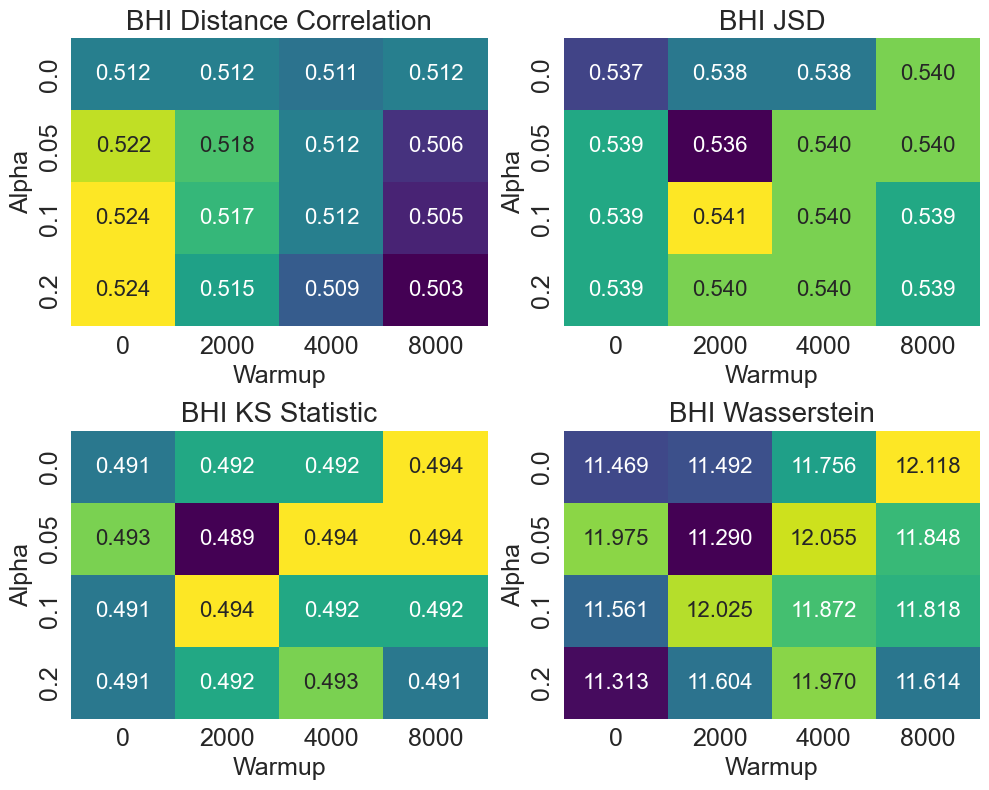

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === Load your summary CSV ===
summary_csv = 'heated_markov_grid_bootstrap_summary.csv'
df = pd.read_csv(summary_csv)

# Ensure required columns exist
expected_cols = {'Alpha', 'Warmup', 'Variable', 'Metric', 'mean'}
assert expected_cols.issubset(df.columns), f"Missing expected columns: {expected_cols - set(df.columns)}"

# === Average across variables ===
df_avg = (
    df.groupby(['Alpha', 'Warmup', 'Metric'], as_index=False)
      .agg({'mean': 'mean'})
)

clean_metric_dict = {
    "Wasserstein": 'Wasserstein',
    "JSD": 'JSD',
    "KS_statistic": 'KS Statistic',
    "Distance_correlation": "Distance Correlation"
}

# === Define grids for consistent ordering ===
alpha_grid = sorted(df_avg['Alpha'].unique())
warmup_grid = sorted(df_avg['Warmup'].unique())


# === Helper to create heatmaps ===
def make_heatmaps_from_summary(df_avg, alpha_grid, warmup_grid):
    metrics = df_avg['Metric'].unique()
    n_metrics = len(metrics)
    ncols = 2
    nrows = int(np.ceil(n_metrics / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axes = axes.ravel()

    for ax, metric in zip(axes, metrics):
        df_metric = df_avg[df_avg['Metric'] == metric]
        # pivot: rows = Alpha, columns = Warmup, values = mean
        grid = (
            df_metric.pivot(index='Alpha', columns='Warmup', values='mean')
                     .reindex(index=alpha_grid, columns=warmup_grid)
        )

        sns.heatmap(
            np.round(grid.astype(float), 3),
            annot=True, fmt=".3f", cmap="viridis",
            cbar=False, ax=ax, annot_kws={"size": 16}
        )

        ax.set_yticks(np.arange(len(alpha_grid)) + 0.5)
        ax.set_yticklabels(np.array(alpha_grid)*0.01, fontsize=18)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
        ax.set_xlabel("Warmup", fontsize=18)
        ax.set_ylabel("Alpha", fontsize=18)
        ax.set_title(f"BHI {clean_metric_dict[metric]}", fontsize=20)

    # Hide unused subplots if any
    for ax in axes[len(metrics):]:
        ax.axis('off')

    plt.tight_layout()
    return fig

# === Generate averaged heatmaps ===
fig = make_heatmaps_from_summary(df_avg, alpha_grid, warmup_grid)
plt.show()

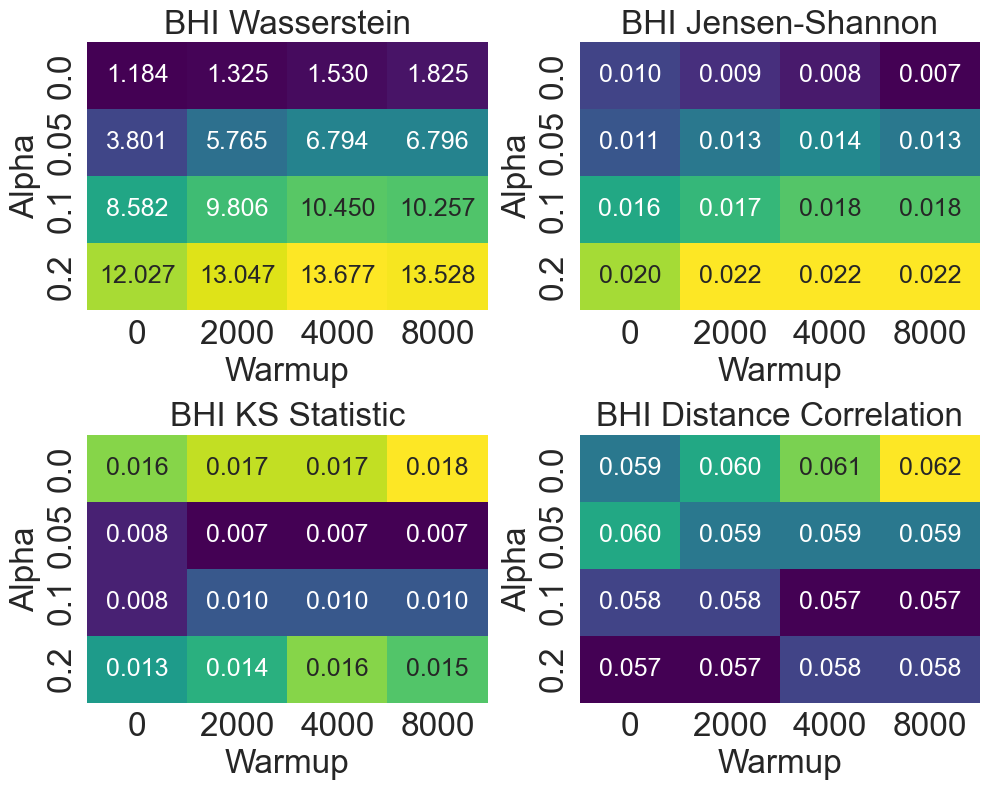

In [12]:



# === Metric dictionaries ===
# Each dict: (alpha, warmup): (abs_val, rel_val)
metrics = {
    "Wasserstein": wasserstein,
    "Jensen-Shannon": jensenshannon,
    "KS Statistic": ks_statistic,
    "Distance Correlation": distance_correlation
}

metrics_std = {
    "Wasserstein": wasserstein_std,
    "Jensen-Shannon": jensenshannon_std,
    "KS Statistic": ks_statistic_std,
    "Distance Correlation": distance_correlation_std
}

alpha_grid = [0, 0.05, 0.1, 0.2]
warmup_grid = [0, 2000, 4000, 8000]

# === Helper function to create heatmaps ===
def make_heatmaps(metrics, alpha_grid, warmup_grid, value_index=0, title_suffix="Absolute"):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    for ax, (name, metric_dict) in zip(axes, metrics.items()):
        # Convert dict to DataFrame with alpha as rows, warmup as columns
        df_metric = pd.DataFrame(index=alpha_grid, columns=warmup_grid, data=np.nan)
        for (alpha, warmup), vals in metric_dict.items():
            if vals is not None and len(vals) > value_index:
                df_metric.loc[alpha, warmup] = vals[value_index]  # 0 for abs, 1 for rel

        sns.heatmap(
            np.round(df_metric.astype(float), decimals = 3),
            annot=True, fmt=".3f", cmap="viridis",
            cbar=False, ax=ax, annot_kws={"size": 18}
        )
        # Assuming your alpha values are the actual index of df_metric
        alpha_labels = df_metric.index.tolist()

        # Set the y-ticks to the positions (0, 1, 2, ...)
        ax.set_yticks(np.arange(len(alpha_labels)) + 0.5) # +0.5 to center the tick on the cell

        # Set the labels to the actual alpha values
        ax.set_yticklabels(alpha_labels, fontsize = 24)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize = 24)
        ax.set_title(f"BHI {name}", fontsize = 24)
        ax.set_xlabel("Warmup", fontsize = 24)
        ax.set_ylabel("Alpha", fontsize = 24)

    plt.tight_layout()
    return fig

# === Plot mean (absolute and relative) ===
fig_abs = make_heatmaps(metrics, alpha_grid, warmup_grid, value_index=0, title_suffix="Mean (Absolute)")
# fig_rel = make_heatmaps(metrics, alpha_grid, warmup_grid, value_index=1, title_suffix="Mean (Relative)")

# === Plot std (absolute and relative) ===
# fig_std_abs = make_heatmaps(metrics_std, alpha_grid, warmup_grid, value_index=0, title_suffix="Std (Absolute)")
# fig_std_rel = make_heatmaps(metrics_std, alpha_grid, warmup_grid, value_index=1, title_suffix="Std (Relative)")

plt.show()


[1.         0.0885187  0.08448479 0.10830679 0.07461477 0.08155832
 0.08698035 0.08297857 0.07396754 0.09436226 0.0666466  0.07444804
 0.08638397 0.06681539 0.07190808 0.07695787 0.07095543 0.05769366
 0.0700835  0.07198911 0.05954037 0.06079107 0.04724984 0.04501241
 0.05112052 0.05484411 0.04657636 0.04964435 0.03671367 0.03876117
 0.04448794]
[ 1.          0.08852309  0.07726229  0.09590121  0.05344847  0.05829385
  0.05997084  0.05358023  0.04105522  0.06060954  0.02845967  0.03690205
  0.04673487  0.0259697   0.03025004  0.03406303  0.02802723  0.01319557
  0.02588334  0.02856915  0.01507195  0.01516603  0.0022383   0.00159489
  0.00868606  0.01431883  0.00606304  0.00906146 -0.00380057  0.00147491
  0.0072666 ]


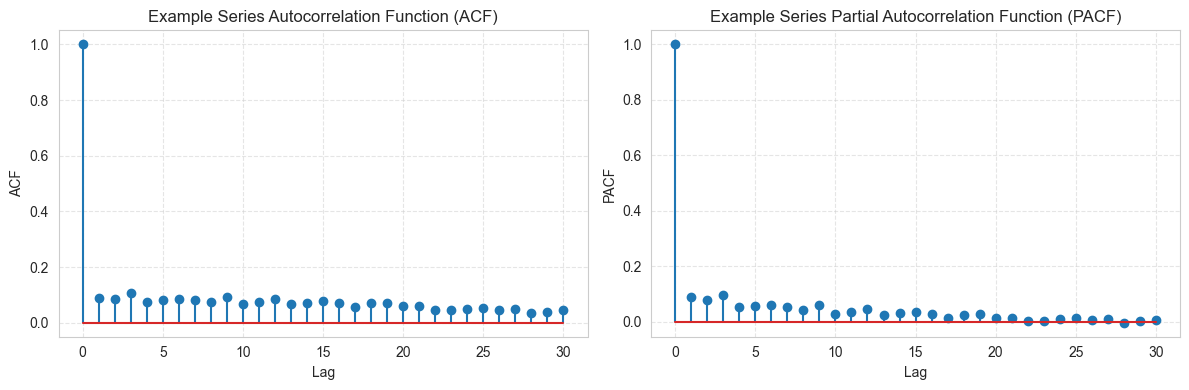

[ 1.          0.36221133  0.32300314  0.22752407  0.16691036  0.18892392
  0.0790153   0.10143705  0.03502894  0.03980772  0.04346954  0.10496461
 -0.02771475 -0.03715056 -0.07947054 -0.15729519 -0.12686787 -0.1388167
 -0.1086436  -0.09589003 -0.15650454 -0.10396072 -0.14015941 -0.12807795
 -0.13465502 -0.12496392 -0.1176869  -0.12342733 -0.15073697 -0.11652281
 -0.07711922]
[ 1.          0.36310348  0.22202704  0.06894063  0.02014213  0.0889449
 -0.05460806  0.02623936 -0.03651677  0.00439625  0.01688334  0.10584521
 -0.12795707 -0.05535248 -0.06724759 -0.12731505 -0.04546954 -0.00233651
 -0.0064588   0.02096236 -0.08976829 -0.0096278  -0.06906508 -0.02258225
 -0.04630696  0.00354221 -0.00870177 -0.03144964 -0.10144271 -0.02589696
 -0.00370426]


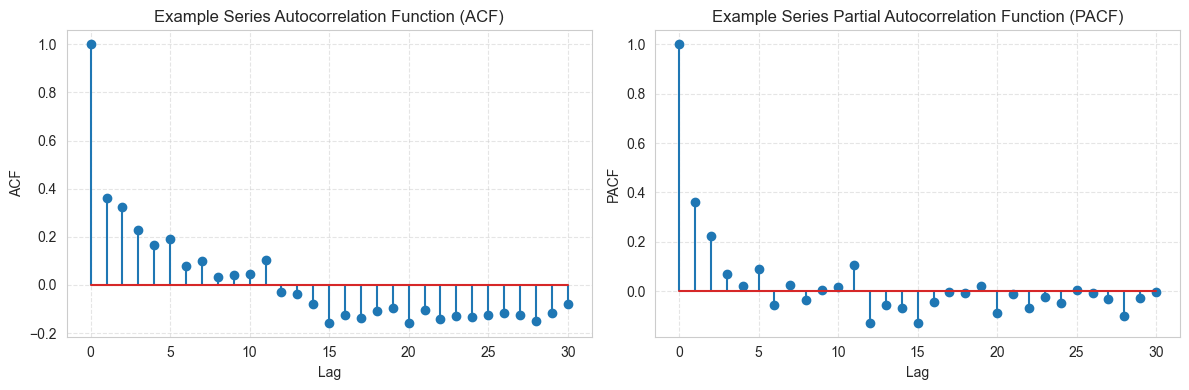

[1.         0.95465517 0.91291117 0.88444613 0.86161328 0.84209674
 0.82456479 0.80888787 0.79504182 0.78221218 0.77026661 0.75951295
 0.74992583 0.74113831 0.73316218 0.72536612 0.71807149 0.71100513
 0.70392562 0.69700306 0.69080087 0.68546084 0.68055786 0.67613613
 0.67170151 0.66741654 0.66375289 0.66044286 0.65727273 0.654066
 0.65018118]
[1.         0.95466088 0.01742994 0.12960042 0.06122486 0.05393117
 0.03826566 0.03640569 0.03476331 0.02615584 0.02461363 0.02656815
 0.02638196 0.02337124 0.02402211 0.01655526 0.01953957 0.01480674
 0.01180119 0.01200861 0.01722017 0.01942757 0.01664827 0.01830456
 0.01250109 0.01395535 0.01805806 0.01574408 0.01434616 0.01189263
 0.00351204]


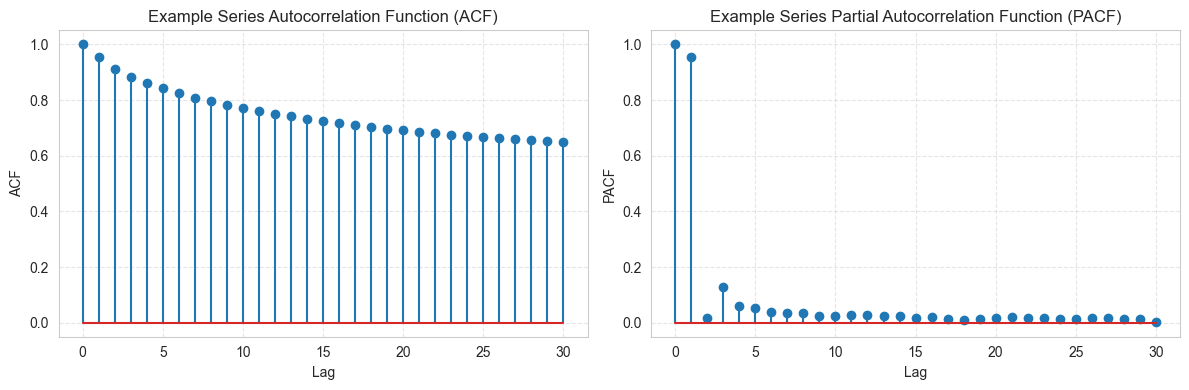

[1.         0.37006206 0.38258415 0.3641819  0.36936671 0.36760002
 0.36398235 0.37574535 0.37225824 0.38087261 0.37672474 0.36563521
 0.37071341 0.37811439 0.35640797 0.3628464  0.36035742 0.35917569
 0.37030212 0.3702183  0.36302472 0.36907588 0.35558181 0.36429041
 0.35048254 0.35869541 0.36881991 0.36594183 0.3699097  0.35010861
 0.35805267]
[1.         0.37008042 0.28464782 0.1987093  0.17234533 0.14529643
 0.12154389 0.12512627 0.10650896 0.10793669 0.09214877 0.06759625
 0.07139725 0.07845797 0.039779   0.04823219 0.04347802 0.03885457
 0.0550341  0.05200302 0.03747453 0.04646512 0.0237402  0.0373713
 0.01701441 0.0280623  0.0440035  0.03733339 0.04018293 0.00998938
 0.02189612]


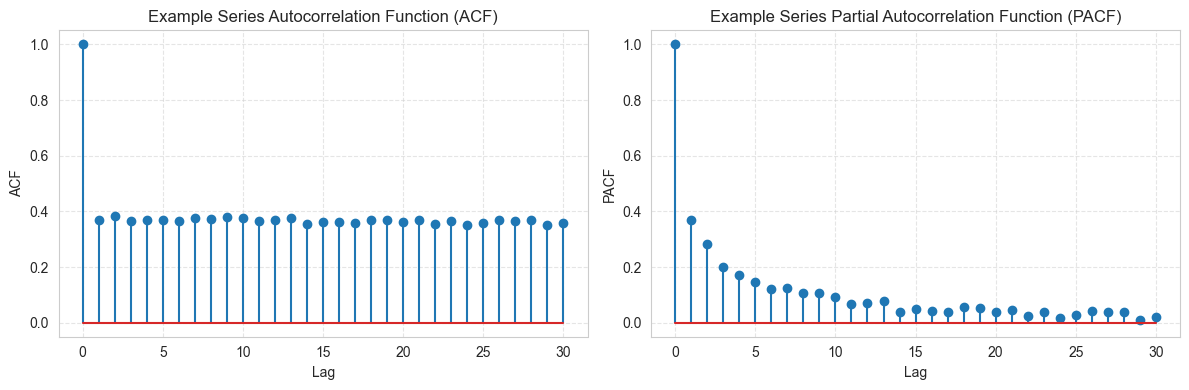

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd

def plot_acf_pacf(data, lags=40, title_prefix=""):
    """
    Compute and plot ACF and PACF for a 1D numpy array.

    Parameters
    ----------
    data : np.ndarray
        1D array of time series data.
    lags : int
        Number of lags to compute.
    title_prefix : str
        Optional prefix for plot titles.
    """
    # Ensure 1D
    data = np.asarray(data).flatten()

    # Compute ACF and PACF
    acf_vals = acf(data, nlags=lags)
    print(acf_vals)
    pacf_vals = pacf(data, nlags=lags, method='yw')
    print(pacf_vals)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ACF
    axes[0].stem(range(len(acf_vals)), acf_vals)
    axes[0].set_title(f"{title_prefix} Autocorrelation Function (ACF)")
    axes[0].set_xlabel("Lag")
    axes[0].set_ylabel("ACF")
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # PACF
    axes[1].stem(range(len(pacf_vals)), pacf_vals)
    axes[1].set_title(f"{title_prefix} Partial Autocorrelation Function (PACF)")
    axes[1].set_xlabel("Lag")
    axes[1].set_ylabel("PACF")
    axes[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return acf_vals, pacf_vals

# Example usage:
# Generate example data (AR(1) process)'
path =  r'C:\Users\Darren\Documents\BHI and Written Qualifier\sim_alpha_0_warmup_0\SynthUser0.csv'
df = pd.read_csv(path)
x = np.array(df['Heart rate___beats/minute'])
acf_vals, pacf_vals = plot_acf_pacf(x, lags=30, title_prefix="Example Series")
path = r'C:\Users\Darren\Documents\BHI and Written Qualifier\SyntheticData\User0.csv'
df = pd.read_csv(path)
x = np.array(df['Heart rate___beats/minute'])
acf_vals, pacf_vals = plot_acf_pacf(x, lags=30, title_prefix="Example Series")
path = r'C:\Users\Darren\Documents\BHI and Written Qualifier\zufferey_data_reformatted\User3.csv'
df = pd.read_csv(path)
x = np.array(df['heartrate'])
acf_vals, pacf_vals = plot_acf_pacf(x, lags=30, title_prefix="Example Series")
path  = r'C:\Users\Darren\Documents\BHI and Written Qualifier\zufferey_synth_data_preprocessed\heart_rate_step_count\SynthUser0.csv'
df = pd.read_csv(path)
x = np.array(df['heartrate'])
acf_vals, pacf_vals = plot_acf_pacf(x, lags=30, title_prefix="Example Series")

In [36]:
import pandas as pd

def compute_dwell_times(states):
    states = np.asarray(states)
    dwell_times = []
    current_state = states[0]
    current_length = 1

    for s in states[1:]:
        if s == current_state:
            current_length += 1
        else:
            dwell_times.append((current_state, current_length))
            current_state = s
            current_length = 1
    dwell_times.append((current_state, current_length))

    df = pd.DataFrame(dwell_times, columns=['state', 'duration'])
    return df


                     mean        std  median  count
state                                              
Aerobic Workout  1.066059   0.266399     1.0    439
Bike             1.041176   0.199285     1.0    170
Outdoor Bike     1.020000   0.140281     1.0    250
Run              1.019868   0.139777     1.0    302
Sport            1.139211   0.393464     1.0    862
Swim             1.026178   0.160084     1.0    191
Walk             1.543433   0.963929     1.0   2383
Weights          1.075758   0.278821     1.0    528
sleep            5.933772  27.586690     1.0   2280
                       mean         std  median  count
state                                                 
Aerobic Workout   23.000000    6.928203    19.0      3
Outdoor Bike      19.000000         NaN    19.0      1
Run               27.125000    9.818896    23.0      8
Swim              15.000000         NaN    15.0      1
Walk              89.733333   87.752761    58.0     30
sleep            887.033333  585.708265   5

In [73]:
import pandas as pd
import numpy as np
import glob
import os

# --- Configuration ---
data_dir = r'C:\Users\Darren\Documents\BHI and Written Qualifier\SyntheticDataFixed'
file_pattern = os.path.join(data_dir, 'User*.csv')

# --- Collect inter-event intervals for all users ---
all_intervals = []

for filepath in glob.glob(file_pattern):
    df = pd.read_csv(filepath)

    # Parse datetime with given format: "year=month-day hour:min"
    df['datetime'] = pd.to_datetime(df['Datetime'], format='%Y=%m-%d %H:%M')
    df = df.sort_values('datetime').reset_index(drop=True)

    # For each activity, compute time to the next occurrence of the same activity
    intervals = []
    for activity, group in df.groupby('Activity_Type'):
        group = group.sort_values('datetime')
        deltas = group['datetime'].diff().dt.total_seconds() / 60.0  # minutes
        deltas = deltas.dropna()
        if len(deltas) > 0:
            intervals.append(pd.DataFrame({
                'Activity_Type': activity,
                'interval': deltas
            }))
    if intervals:
        all_intervals.append(pd.concat(intervals, ignore_index=True))

# --- Combine all users ---
df_all = pd.concat(all_intervals, ignore_index=True)

# --- Compute average inter-event interval per activity ---
activity_stats = df_all.groupby('Activity_Type')['interval'].agg(['mean', 'std', 'count']).reset_index()

# --- Compute Poisson rate λ = 1 / mean inter-event interval ---
activity_stats['lambda'] = 1.0 / activity_stats['mean']

# --- Compute total rate and thinning probabilities ---
lambda_total = activity_stats['lambda'].sum()
activity_stats['probability'] = activity_stats['lambda'] / lambda_total

# --- Sort descending by rate for readability ---
activity_stats = activity_stats.sort_values('lambda', ascending=False).reset_index(drop=True)

print(activity_stats)

# --- Save results ---
out_path = os.path.join(data_dir, 'activity_poisson_rates.csv')
activity_stats.to_csv(out_path, index=False)

print(f"\nSaved Poisson rate parameters and thinning probabilities to {out_path}")


          Activity_Type         mean          std  count    lambda  \
0           Light Sleep   159.878584   606.811064  11127  0.006255   
1  No Physical Activity   193.677767   588.214563   9459  0.005163   
2               Running   235.048397   617.483577   7955  0.004254   
3        Floors Climbed   423.685904   860.944582   4228  0.002360   
4             REM Sleep   610.958639  1497.611475   2587  0.001637   
5               Walking  3391.197802  3941.208820    273  0.000295   

   probability  
0     0.313297  
1     0.258622  
2     0.213103  
3     0.118223  
4     0.081985  
5     0.014770  

Saved Poisson rate parameters and thinning probabilities to C:\Users\Darren\Documents\BHI and Written Qualifier\SyntheticDataFixed\activity_poisson_rates.csv


In [126]:
def thin_df(df, activity_stats, synth = False):
    """
    Apply Poisson thinning to a dataframe using rate ratios from activity_stats.
    Each activity is thinned according to p = λ_activity / λ_max.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Datetime' and 'Activity_Type' columns.
    activity_stats : pd.DataFrame
        Must contain columns ['Activity_Type', 'lambda'] from previous analysis.

    Returns
    -------
    df_thinned : pd.DataFrame
        Thinned dataframe preserving original structure but with some rows removed.
    """
    # Ensure datetime is parsed
    if synth:
        df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')
    else:
        df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y=%m-%d %H:%M', errors='coerce')
    df = df.dropna(subset=['Datetime'])
    df = df.sort_values('Datetime').reset_index(drop=True)
    # Determine the maximum lambda (parent rate)
    lambda_sum = activity_stats['lambda'].sum()

    thinned_records = []
    for activity, group in df.groupby('Activity_Type'):
        # Get lambda for this activity
        row = activity_stats[activity_stats['Activity_Type'] == activity]
        if row.empty:
            continue

        lambda_child = row['lambda'].values[0]
        # Thinning probability = λ_child / λ_parent
        p = lambda_child

        # Randomly retain events with probability p
        keep_mask = np.random.rand(len(group)) < p
        thinned_records.append(group[keep_mask])
    # Recombine all thinned activity groups
    if len(thinned_records) > 0:
        df_thinned = pd.concat(thinned_records, ignore_index=True)
        df_thinned = df_thinned.sort_values('Datetime').reset_index(drop=True)
    else:
        df_thinned = pd.DataFrame(columns=df.columns)

    return df_thinned
np.random.seed(42)
# path = r'C:\Users\Darren\Documents\BHI and Written Qualifier\zufferey_synth_data\SynthUser0.csv'
path =  r'C:\Users\Darren\Documents\BHI and Written Qualifier\sim_alpha_0_warmup_0\SynthUser0.csv'
df = augment_data(thin_df(pd.read_csv(path), activity_stats, synth = True))
df.to_csv('test_csv.csv',index=False)
# states = np.array(df['activity'])
states = np.array(df['Activity_Type'])
df_dwell = compute_dwell_times(states)
summary_synth = df_dwell.groupby('state')['duration'].agg(['mean', 'std', 'median', 'count'])
print(summary_synth)
# print(df_dwell)
# path = r'C:\Users\Darren\Documents\BHI and Written Qualifier\zufferey_data_reformatted_preprocessed\activity\User1.csv'
# path = r'C:\Users\Darren\Documents\BHI and Written Qualifier\SyntheticData\User0.csv'
path = r'C:\Users\Darren\Documents\BHI and Written Qualifier\SyntheticDataFixed\User0.csv'
df = augment_data(pd.read_csv(path))
# states = np.array(df['activity'])
states = np.array(df['Activity_Type'])
df_dwell = compute_dwell_times(states)
summary_ref = df_dwell.groupby('state')['duration'].agg(['mean', 'std', 'median', 'count'])
print(summary_ref)
# print(df_dwell)

print((summary_synth['mean'] - summary_ref['mean']).abs()/ (summary_ref['mean']))

                           mean        std  median  count
state                                                    
Floors Climbed         1.200000   0.447214     1.0      5
Light Sleep           13.952381  10.480821    12.0     21
No Physical Activity   1.684211   1.293257     1.0     19
REM Sleep              2.333333   0.577350     2.0      3
Running                3.500000   2.390457     2.5      8
                           mean        std  median  count
state                                                    
Floors Climbed         1.571429   1.372442     1.0     28
Light Sleep           23.861538  32.761390    18.0     65
No Physical Activity   1.932203   1.946388     1.0     59
REM Sleep              3.052632   3.763475     2.0     19
Running                5.358491   5.000363     3.0     53
Walking               17.200000   5.630275    19.0      5
state
Floors Climbed          0.236364
Light Sleep             0.415277
No Physical Activity    0.128347
REM Sleep               0

In [9]:
import os
import pandas as pd
import numpy as np

# ========= CONFIG =========
input_dir = "reference_results"
output_csv = "reference_metric_stats_bhi.csv"

# ========= LOAD ALL _vs_ FILES =========
dfs = []
for f in os.listdir(input_dir):
    if f.endswith(".csv") and "_vs_" in f:
        df = pd.read_csv(os.path.join(input_dir, f), index_col=0)
        if "Comparison" in df.index:
            df = df.drop(index="Comparison")
        dfs.append(df)

if not dfs:
    raise ValueError("No _vs_ CSV files found.")

# Concatenate on rows by aligning index + columns
df_all = pd.concat(dfs, axis=0)

# Keep numeric data only
df_all = df_all.apply(pd.to_numeric, errors="coerce").dropna(how="all")

# Melt into long form: each row -> (Variable, Metric, Value)
df_long = df_all.reset_index().melt(id_vars=df_all.index.name or "index",
                                    var_name="Metric",
                                    value_name="Value")
df_long.rename(columns={df_all.index.name or "index": "Variable"}, inplace=True)

# Drop missing
df_long = df_long.dropna(subset=["Value"])

# ========= SUMMARY COMPUTATION =========
summary = (
    df_long.groupby(["Variable", "Metric"])["Value"]
        .agg([
            ("mean", "mean"),
            ("std", "std"),
            ("median", "median"),
            ("IQR_25", lambda x: np.percentile(x, 25)),
            ("IQR_75", lambda x: np.percentile(x, 75)),
            ("min", "min"),
            ("max", "max"),
            ("95%_CI_low", lambda x: np.percentile(x, 2.5)),
            ("95%_CI_high", lambda x: np.percentile(x, 97.5))
        ])
        .reset_index()
)

# ========= SAVE =========
summary.to_csv(output_csv, index=False)

print("\n✅ Summary computed and saved:", output_csv)
print(summary.head(15))



✅ Summary computed and saved: reference_metric_stats_bhi.csv
                     Variable                Metric       mean        std  \
0               Activity_Type                   JSD   0.106528   0.043999   
1        Calories burned_kcal  Distance_correlation   0.243613   0.130970   
2        Calories burned_kcal                   JSD   0.340016   0.057480   
3        Calories burned_kcal          KS_statistic   0.196810   0.114102   
4        Calories burned_kcal           Wasserstein  18.242721  12.797375   
5         Exercise duration_s  Distance_correlation   0.240426   0.087578   
6         Exercise duration_s                   JSD   0.416991   0.049621   
7         Exercise duration_s          KS_statistic   0.203115   0.101294   
8         Exercise duration_s           Wasserstein  96.278735  60.849859   
9     Floors climbed___floors  Distance_correlation   0.000000   0.000000   
10    Floors climbed___floors                   JSD   0.000000   0.000000   
11    Floors c

In [13]:
import os
import pandas as pd
import numpy as np

# ========= CONFIG =========
input_dir = r"C:\Users\Darren\Documents\BHI and Written Qualifier\ctgan\comparison_summary_zufferey"  # directory of *_results.csv files
output_csv = "reference_metric_stats_fitbit.csv"

# Recognized metric names from filename prefixes
metric_name_map = {
    "Wasserstein": "Wasserstein",
    "JSD": "JSD",
    "KS": "KS_statistic",
    "DistCorr": "Distance_correlation",
    "DistanceCorr": "Distance_correlation"
}

records = []

# ========= LOAD AND STACK DATA =========
for fname in os.listdir(input_dir):
    if not fname.endswith("_results.csv"):
        continue

    metric_key = fname.split("_results.csv")[0]
    if metric_key not in metric_name_map:
        print(f"⚠️ Skipping unrecognized file name: {fname}")
        continue

    metric = metric_name_map[metric_key]
    path = os.path.join(input_dir, fname)

    df = pd.read_csv(path, index_col=0)

    # Drop "Comparison" index row
    if "Comparison" in df.index:
        df = df.drop(index="Comparison", errors="ignore")

    # Convert to numeric only
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.dropna(axis=1, how="all")

    # Reshape into long format: (Variable, Value)
    df_long = df.melt(var_name="Variable", value_name="Value")
    df_long = df_long.dropna(subset=["Value"])
    df_long["Metric"] = metric

    records.append(df_long)

if not records:
    raise ValueError("No usable *_results.csv files found.")

df_all = pd.concat(records, ignore_index=True)

# ========= SUMMARY STATISTICS ACROSS FILES =========
summary = (
    df_all.groupby(["Variable", "Metric"])["Value"]
        .agg([
            ("mean", "mean"),
            ("std", "std"),
            ("median", "median"),
            ("IQR_25", lambda x: np.percentile(x, 25)),
            ("IQR_75", lambda x: np.percentile(x, 75)),
            ("min", "min"),
            ("max", "max"),
            ("95%_CI_low", lambda x: np.percentile(x, 2.5)),
            ("95%_CI_high", lambda x: np.percentile(x, 97.5)),
        ])
        .reset_index()
)

# ========= SAVE RESULT =========
summary.to_csv(output_csv, index=False)

print("\n✅ Summary saved to:", output_csv)
print(summary.head(12))


✅ Summary saved to: reference_metric_stats_fitbit.csv
             Variable                Metric       mean        std     median  \
0            activity  Distance_correlation   0.155197   0.089584   0.135033   
1            activity                   JSD   0.676266   0.092902   0.686805   
2            activity          KS_statistic   0.510684   0.190195   0.514286   
3            activity           Wasserstein   1.725296   0.706459   1.683393   
4   activity_duration  Distance_correlation   0.185344   0.079374   0.166813   
5   activity_duration                   JSD   0.477226   0.098597   0.471100   
6   activity_duration          KS_statistic   0.297971   0.124060   0.278689   
7   activity_duration           Wasserstein  15.690110  17.577586  13.285195   
8           heartrate  Distance_correlation   0.194766   0.085153   0.174744   
9           heartrate                   JSD   0.460119   0.095275   0.451386   
10          heartrate          KS_statistic   0.291158   0.089701